# Project1: End-to-End Pipeline to Classify News Articles
*   505851728 Yang-Shan Chen
*   005627440 Chih-En Lin
*   505297814 Rikako Hatoya

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
import re
import nltk
#nltk.download("all")
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import words
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


# Question 1

In [3]:
data = pd.read_csv('Project_1_dataset_01_01_2022.csv')
#Overview
print("rows = "+str(data.shape[0])+"\n"+"columns = "+str(data.shape[1]))

rows = 2072
columns = 9


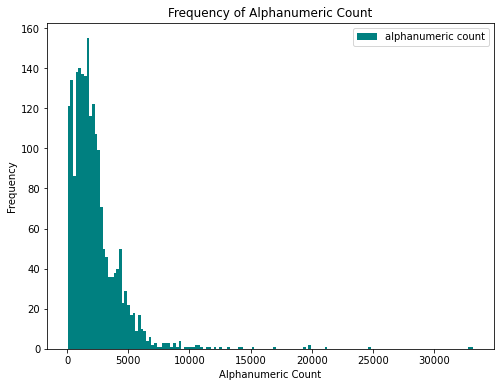

In [4]:
#Histograms
#(a)
count_alphanumeric = []
for row in range(data.shape[0]):
    count_alphanumeric.append(sum([c.isalnum() for c in data.iat[row,1]]))
data_a=pd.DataFrame({'alphanumeric count':count_alphanumeric})
histogram_alphanumeric=data_a.plot.hist(bins=150, color='teal',figsize=(8,6))
histogram_alphanumeric.set_title("Frequency of Alphanumeric Count")
histogram_alphanumeric.set_xlabel("Alphanumeric Count")
histogram_alphanumeric.set_ylabel("Frequency")
plt.show()

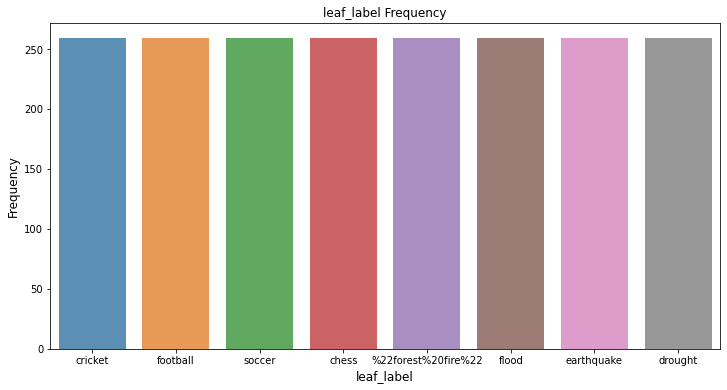

In [7]:
#(b)
plt.figure(figsize=(12,6))
histogram_leaflabel=sns.barplot(x=data['leaf_label'].value_counts().index, y=data['leaf_label'].value_counts().values, alpha=0.8)
plt.title('leaf_label Frequency')
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('leaf_label', fontsize=12)
plt.show()

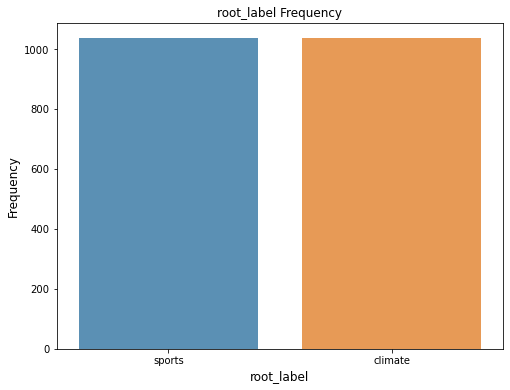

In [8]:
#(c)
plt.figure(figsize=(8,6))
histogram_rootlabel=sns.barplot(x=data['root_label'].value_counts().index, y=data['root_label'].value_counts().values, alpha=0.8)
plt.title('root_label Frequency')
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('root_label', fontsize=12)
plt.show()

**Histogram interpretations:**

For both leaf_label and root_label, frequencies for each category is evenly distributed. As for the alphanumerical lengths, most posts lie under 10,000 characters and the mode lies near 2,500 characters.

# Question 2

In [5]:
np.random.seed(42)
random.seed(42)
train, test = train_test_split(data[["full_text","root_label","leaf_label"]], test_size=0.2)
print("training samples = "+str(len(train))+"\n"+"test samples = "+str(len(test)))

training samples = 1657
test samples = 415


# Question 3

**Cleaning Data:**
Each full_string is cleaned using the following processor by removing HTML artefacts as well as removing any URLs, e-mail address, and any words that contain numbers.

In [6]:
###Cleaning Preprocessor
#Cleans the data, removes raw input other than text
def clean(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'www.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\S*@\S*\s?', '', text, flags=re.MULTILINE) #remove email address
    text=re.sub(r'\w*\d+\w*', '', text).strip() #remove any word with numbers
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub('\__', "", texter)
    texter = re.sub('\|', "", texter)
    texter = re.sub('\/', " ", texter)
    texter = re.sub('--', "", texter)
    texter = re.sub(r'\d+', '', texter) #remove word with just numbers
    texter = re.sub(' u '," you ", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub(' &amp; ', ' and ', texter)
    texter = re.sub('\r', ' ',texter)
    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    if texter == "":
        texter = ""
    return texter
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

stop_words = text.ENGLISH_STOP_WORDS
english_vocab = set(w.lower() for w in nltk.corpus.words.words())

**Lemmatizing Data:**
Each word from full_text corpus is extracted, examined whether they are included in the NLTK English vocabulary list, if the letters are in English, and whether they are not included in the English stop words list. If the word clears these 3 cases, they are then lemmatized and returned back to its corpus.

In [7]:
###Lemmatizer (Reference: https://www.machinelearningplus.com/nlp/lemmatization-examples-python/)
#Check each word inside each of the full_text corpus, makes words lower-case, removes non-English words
#converts words to its simplest form i.e plural to singluar, etc using lemmatizer
#appends that word, joins them into a sentence and adds it to lemmatized_full_text

cleaned_train_full_text=[]
cleaned_test_full_text=[]
for row in range(train.shape[0]):
    cleaned_train_full_text.append(clean(train.iat[row,0]))
for row in range(test.shape[0]):
    cleaned_test_full_text.append(clean(test.iat[row,0]))

lemmatizer = WordNetLemmatizer()

lemmatized_train_full_text=[]
lemmatized_test_full_text=[]

for full_text in cleaned_train_full_text:
    wordlist=[]
    for word in nltk.word_tokenize(full_text):
        word=word.lower()
        if (word in english_vocab) and word.isalpha() and ((word in stop_words) == False):
            word=lemmatizer.lemmatize(word, get_wordnet_pos(word))
            wordlist.append(word)
    lemmatized_train_full_text.append(' '.join(wordlist))
for full_text in cleaned_test_full_text:
    wordlist=[]
    for word in nltk.word_tokenize(full_text):
        word=word.lower()
        if (word in english_vocab) and word.isalpha() and ((word in stop_words) == False):
            word=lemmatizer.lemmatize(word, get_wordnet_pos(word))
            wordlist.append(word)
    lemmatized_test_full_text.append(' '.join(wordlist))

In [10]:
###Initialization
tfidf_transformer=TfidfTransformer()
vectorizer=CountVectorizer(min_df=3)
###train
train_count=vectorizer.fit_transform(lemmatized_train_full_text) #fitting my model and vectorizing it
train_tfidf=tfidf_transformer.fit_transform(train_count).toarray()
###test
test_count=vectorizer.transform(lemmatized_test_full_text) #transform doesn't add new vocabs as where fit_transform trained vocabs
test_tfidf=tfidf_transformer.transform(test_count).toarray()

In [7]:
print("The shape of the training matrix is ({}, {})".format(train_tfidf.shape[0],train_tfidf.shape[1]))
print("The shape of the test matrix is ({}, {})".format(test_tfidf.shape[0],test_tfidf.shape[1]))

The shape of the training matrix is (1657, 6759)
The shape of the test matrix is (415, 6759)


In [11]:
###assigning each document category names to category numbers
#making a list of all category types
#0:sports; 1:climate
train_rootlabel_categories = data['root_label'].value_counts().index.tolist()
#making a list of all document categories using category numbers
train_rootlabel_numbers = []

for row in range(train.shape[0]):
    for i, s in enumerate(train_rootlabel_categories):
        if train.iat[row,1] == s:
            train_rootlabel_numbers.append(i)
            break

train_rootlabel_numbers=np.asarray(train_rootlabel_numbers)
#######################################
test_rootlabel_numbers=[]

for row in range(test.shape[0]):
    for i, s in enumerate(train_rootlabel_categories):
        if test.iat[row,1] == s:
            test_rootlabel_numbers.append(i)
            break

test_rootlabel_numbers=np.asarray(test_rootlabel_numbers)

1. What are the pros and cons of lemmatization versus stemming? How do these processes affect the dictionary size?

Stemming tries to remove the prefixes/suffixes of the word until its stem is reached as where lemmatization would look for the category of a word and uses a full dictionary to conduct a morphological analysis to get its lemma.

2. min_df means minimum document frequency. How does varying min df change the TF-IDF matrix?

Since mindf selects words to store in the dictionary from CountVectorizer if a certain word appears in the file more than the value of mindf, if mindf is increased, the number of vocabularies in the dictionary would decrease and if mindf is decreased, the vice versa occurs.

3. Should I remove stopwords before or after lemmatizing? Should I remove punctuations before or after lemmatizing? Should I remove numbers before or after lemmatizing?

Remove stopwords before lemmatizing because otherwise, stopwords wouldn't be able to remove all the stop words if each word were modified to its lemma. Numbers and punctuations should be removed before lemmatizing since lemmatize only works for words. This is done in my program by only lemmatizing elements in my word list that are english vocabs and checking that they only contain english letters using word.isalpha().

4. Report the shape of the TF-IDF-processed train and test matrices. The number of rows should match the results of Question 2. The number of columns should roughly be in the order of k×10^3. This dimension will vary depending on your exact method of cleaning and lemmatizing and that is okay.

for train tfidf: (1657, 6753) for test tfidf: (415, 6753)

# Question 4

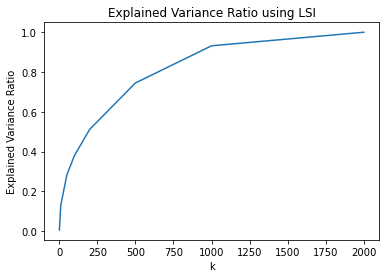

In [15]:
###LSI explained variance ratio plot
explained_variance_ratio_sum=[]
k_values=[1,10,50,100,200,500,1000,2000]

for k in k_values:
    lsi = TruncatedSVD(n_components=k, n_iter=10, random_state=42)
    lsi.fit_transform(train_tfidf)
    explained_variance_ratio_sum.append(lsi.explained_variance_ratio_.sum())

plt.plot(k_values, explained_variance_ratio_sum)
plt.xlabel('k')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio using LSI')
plt.show()

This concavity suggests that the explained variance ratio increases rapidly when k is smaller and then decreases change as k-values increase. However, increasing k would also mean that the model gains complexity.

In [12]:
###LSI, residual error
import scipy.sparse.linalg
from numpy import linalg as LA #frobenius norm function
U, s, Vk_T = scipy.sparse.linalg.svds(train_tfidf, k=50)
Vk=Vk_T.transpose()
reduced_lsi_train=np.dot(train_tfidf, Vk)
reduced_lsi_test=np.dot(test_tfidf, Vk)
print("LSI residual MSE error= "+str((LA.norm(train_tfidf-np.dot(reduced_lsi_train, Vk_T), 'fro')**2)))

LSI residual MSE error= 1146.5211352451013


In [17]:
###NMF, residual error
#(Reference: https://qiita.com/takechanman1228/items/6d1f65f94f7aaa016377)
#W_train and W_test are the dimension reduced matrix, H_train is the keyword list
model_nmf = NMF(n_components=50, init='random', random_state=42, max_iter=1000)
W_train = model_nmf.fit_transform(train_tfidf)
H_train = model_nmf.components_
W_test=model_nmf.transform(test_tfidf)

#reconstruction residual MSE error
print("NMF residual MSE error= "+str(model_nmf.reconstruction_err_**2))

NMF residual MSE error= 1173.0485586513678


The error is lower for LSI than NMF. Since NMF only allows positive entries after reduction, meanwhile, LSI maintains max variance and can have negative entries. Hence, LSI represents the higher-dimensional matrix better, providing a deeper factorization with lower information loss than NMF.


# Question 5

In [8]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix, recall_score, precision_score, f1_score

def plt_roc_curve(model, txt):
    prob = model.predict_proba(reduced_lsi_test)[:,1]
    fpr, tpr, thresholds = roc_curve(test_rootlabel_numbers, prob)
    plt.plot(fpr, tpr)
    plt.title("ROC Curve: "+txt)
    plt.xlabel('FPR: False positive rate')
    plt.ylabel('TPR: True positive rate')
    plt.show()

def plt_confusion_matrix(pred_test, txt):
    cmx_data = confusion_matrix(test_rootlabel_numbers, pred_test) 
    df_cmx = pd.DataFrame(cmx_data)
    sns.heatmap(df_cmx, fmt='d', annot=True, square=True)
    plt.title('Confusion Matrix for '+txt)  
    plt.xlabel('Predicted Category')
    plt.ylabel('True Category')
    plt.show()

def arpf(pred_test):
    print("accuracy of test data: "+str(accuracy_score(test_rootlabel_numbers, pred_test)))
    print("recall: "+str(recall_score(test_rootlabel_numbers, pred_test)))
    print("precision: "+str(precision_score(test_rootlabel_numbers, pred_test)))
    print("F-1 Score: "+str(f1_score(test_rootlabel_numbers, pred_test)))

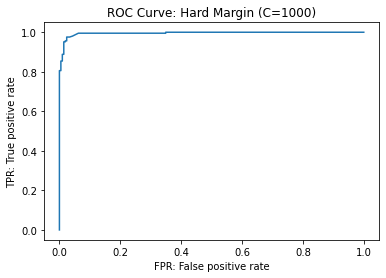

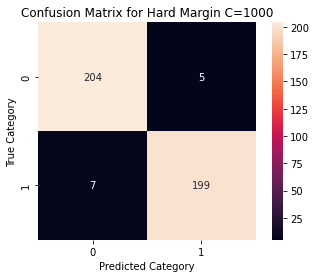

accuracy of test data: 0.9710843373493976
recall: 0.9660194174757282
precision: 0.9754901960784313
F-1 Score: 0.9707317073170731


In [19]:
###Hard Margin
#training classifier and predicting

clf_hardmargin = SVC(kernel='linear', random_state=42, C=1000, probability=True)
clf_hardmargin.fit(reduced_lsi_train, train_rootlabel_numbers)

pred_test = clf_hardmargin.predict(reduced_lsi_test)

#ROC curve
plt_roc_curve(clf_hardmargin, 'Hard Margin (C=1000)')

#confusion matrix
plt_confusion_matrix(pred_test, 'Hard Margin C=1000')

#accuracy, recall, precision, F-1 Score
arpf(pred_test)

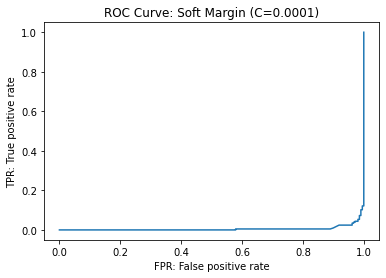

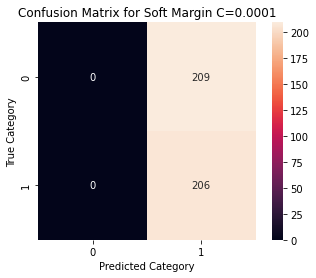

accuracy of test data: 0.4963855421686747
recall: 1.0
precision: 0.4963855421686747
F-1 Score: 0.6634460547504025


In [20]:
###Soft Margin
#training classifier and predicting
clf_softmargin = SVC(kernel='linear', random_state=42, C=0.0001, probability=True)
clf_softmargin.fit(reduced_lsi_train, train_rootlabel_numbers)

pred_test = clf_softmargin.predict(reduced_lsi_test)

#ROC curve
plt_roc_curve(clf_softmargin, 'Soft Margin (C=0.0001)')

#confusion matrix
plt_confusion_matrix(pred_test, 'Soft Margin C=0.0001')

#accuracy, recall, precision, F-1 Score
arpf(pred_test)

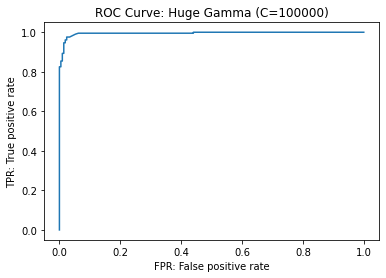

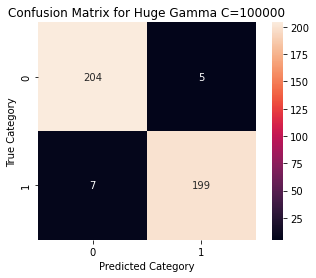

accuracy of test data: 0.9710843373493976
recall: 0.9660194174757282
precision: 0.9754901960784313
F-1 Score: 0.9707317073170731


In [21]:
###huge Gamma
#training classifier and predicting
clf_hugemargin = SVC(kernel='linear', random_state=42, C=100000, probability=True)
clf_hugemargin.fit(reduced_lsi_train, train_rootlabel_numbers)

pred_test = clf_hugemargin.predict(reduced_lsi_test)

#ROC curve
plt_roc_curve(clf_hugemargin, 'Huge Gamma (C=100000)')

#confusion matrix
plt_confusion_matrix(pred_test, 'Huge Gamma C=100000')

#accuracy, recall, precision, F-1 Score
arpf(pred_test)

According to the confusion matrices, adopting a huge gamma or a hard margin results to a  better classification than using a soft margin. For soft margin, we can see that all predicted labels are the same. This is due to giving the model too much regularization. Hence, even if we have the incorrect predictions, the penalty is subtle compared by the regularization term. Furthermore, the ROC curve for soft margin appears on the right-bottom corner, which indicates as being incompetitive.

Best Parameters: {'C': 0.1}
Best Score: 0.9474884431987769


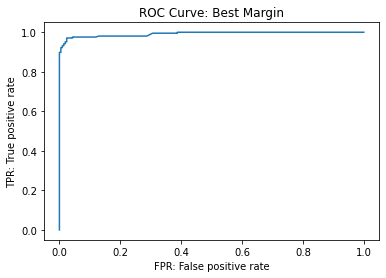

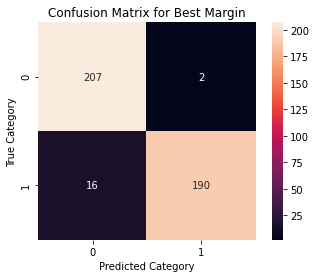

accuracy of test data: 0.9566265060240964
recall: 0.9223300970873787
precision: 0.9895833333333334
F-1 Score: 0.9547738693467336


In [11]:
#Cross-Validation (Reference: https://aiacademy.jp/texts/show/?id=299)
from sklearn.model_selection import GridSearchCV

candidate_params = {'C': [10**i for i in range(-3, 7)]}

svc = SVC(kernel='linear', random_state=42, probability=True, max_iter=10000)
clf = GridSearchCV(estimator=svc, param_grid=candidate_params, cv=5, n_jobs=-1)
clf.fit(reduced_lsi_train, train_rootlabel_numbers)
print("Best Parameters: "+str(clf.best_params_))
print("Best Score: "+str(clf.best_score_))

#training classifier and predicting
clf = SVC(kernel='linear', random_state=42, C=clf.best_params_['C'], probability=True)
clf.fit(reduced_lsi_train, train_rootlabel_numbers)

pred_test = clf.predict(reduced_lsi_test)

#ROC curve
plt_roc_curve(clf, 'Best Margin')

#confusion matrix
plt_confusion_matrix(pred_test, 'Best Margin')

#accuracy, recall, precision, F-1 Score
arpf(pred_test)

# Question 6

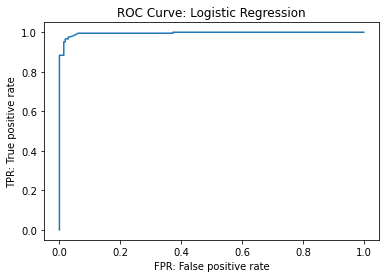

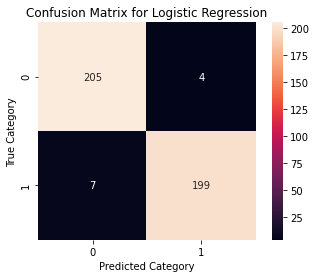

accuracy of test data: 0.9734939759036144
recall: 0.9660194174757282
precision: 0.9802955665024631
F-1 Score: 0.9731051344743277


In [13]:
###No regularization
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='none', max_iter=10000, tol=0.0001, solver='saga', random_state=42)
clf.fit(reduced_lsi_train, train_rootlabel_numbers)
pred_test = clf.predict(reduced_lsi_test)

#ROC curve
plt_roc_curve(clf, 'Logistic Regression')

#confusion matrix
plt_confusion_matrix(pred_test, 'Logistic Regression')

#accuracy, recall, precision, F-1 Score
arpf(pred_test)

In [59]:
###Optimal regularization strength for L1 and L2 using cross-validation
candidate_params = {'C': [10**i for i in range(-4, 5)]}
lgr=LogisticRegression(penalty='l1', solver='saga', max_iter=10000, tol=0.0001, random_state=42)
clf = GridSearchCV(estimator=lgr, param_grid=candidate_params, cv=5)
clf.fit(reduced_lsi_train, train_rootlabel_numbers)
print('L1 regularization')
print("Optimal C: "+str(clf.best_params_['C']))
print("Best Score: "+str(clf.best_score_))
print('\n')

lgr=LogisticRegression(penalty='l2', solver='saga', max_iter=10000, tol=0.0001, random_state=42)
clf = GridSearchCV(estimator=lgr, param_grid=candidate_params, cv=5)
clf.fit(reduced_lsi_train, train_rootlabel_numbers)
print('L2 regularization')
print("Optimal C: "+str(clf.best_params_['C']))
print("Best Score: "+str(clf.best_score_))

L1 regularization
Optimal C: 10
Best Score: 0.94990536162778


L2 regularization
Optimal C: 10
Best Score: 0.9529174098205511


In [60]:
###No regularization
clf = LogisticRegression(penalty='none', solver='saga', max_iter=10000, tol=0.0001, random_state=42)
clf.fit(reduced_lsi_train, train_rootlabel_numbers)
pred_test = clf.predict(reduced_lsi_test)
#accuracy, recall, precision, F-1 Score
print('no regularization')
arpf(pred_test)
print('\n')
###L1
clf=LogisticRegression(penalty='l1', solver='saga', C=10, max_iter=10000, tol=0.0001, random_state=42)
clf.fit(reduced_lsi_train, train_rootlabel_numbers)
pred_test = clf.predict(reduced_lsi_test)
#accuracy, recall, precision, F-1 Score
print('L1 regularization')
arpf(pred_test)
print('\n')
###L2
clf=LogisticRegression(penalty='l2', solver='saga', C=10, max_iter=10000, tol=0.0001, random_state=42)
clf.fit(reduced_lsi_train, train_rootlabel_numbers)
pred_test = clf.predict(reduced_lsi_test)
#accuracy, recall, precision, F-1 Score
print('L2 regularization')
arpf(pred_test)

no regularization
accuracy of test data: 0.9734939759036144
recall: 0.9660194174757282
precision: 0.9802955665024631
F-1 Score: 0.9731051344743277


L1 regularization
accuracy of test data: 0.9686746987951808
recall: 0.9660194174757282
precision: 0.9707317073170731
F-1 Score: 0.9683698296836983


L2 regularization
accuracy of test data: 0.9710843373493976
recall: 0.9660194174757282
precision: 0.9754901960784313
F-1 Score: 0.9707317073170731


Overall, the performance is no regularization > L2 > L1. However, there is small difference between each.

For these three models, if one wants to follow the training data as closely as possible by avoiding overfitting to occur, "no regularization" is preferred.


L1 regularization is suitable for feature selection, simple and sparse models, and features associated with 0 weights can be discarded. The reason is that L1 regularization encourages all kinds of weights to shrink to 0, regardless of size of w. L1 regularization is more likely to zero out the coefficients than L2 regularization for similar test accuracies because it assumes prior on the weights sampled from an isotropic Laplace distribution.


L2 regularization, which assumes in prior from the weights sampled from a Gaussian distribution, is suitable for reducing the effects of collinear features, which can lead to increased variance (hence instability and sensitivity to outliers) of the model.


For differences between SVM and Logistic regression

Logistic regression uses classic MLP method to construct its loss function. The goal is to maximize the conditional likelihood of correct classification on the entire training set. SVM is geometric in nature, using only some points closest to the decision boundary, which we called support vectors to find our optimal hyperplane. This enables to maximize the distance of the margin. Therefore, logistic regression does not guarantee it will yield an optimal decision boundary, whereas SVM yields the best separating hyperplane that reduces misclassification rate.

Logistic regression is more likely to cause overfitting since its decision is based on the entire training set, whereas SVM provides better generalization. In addition, logistic loss is sensitive to outliers and does not go to zero. As for hinge loss it can be 0 and is definitely less sensitive to outliers. As discussed earlier, logistic regression provides high confidence in classifying data further away from the hyperplane but fails for samples near the margin. SVM is more efficient and fast at handling complex, high-dimensional and unstructured data through the kernel trick. Logistic regression is more suitable for structured datasets.

# Question 7

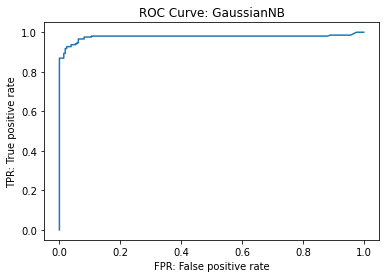

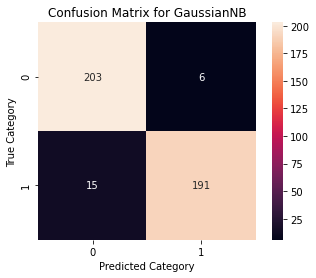

accuracy of test data: 0.9493975903614458
recall: 0.9271844660194175
precision: 0.9695431472081218
F-1 Score: 0.9478908188585609


In [14]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(reduced_lsi_train, train_rootlabel_numbers)
pred_test = clf.predict(reduced_lsi_test)

#ROC curve
plt_roc_curve(clf, 'GaussianNB')

#confusion matrix
plt_confusion_matrix(pred_test, 'GaussianNB')

#accuracy, recall, precision, F-1 Score
arpf(pred_test)

# Question 8

In [62]:
#from nltk.stem import PorterStemmer
import time
from tempfile import mkdtemp
from joblib import Memory
from nltk.stem.lancaster import LancasterStemmer as LS

raw_data_train = [train.iat[row,0] for row in range(train.shape[0])] #text
raw_data_test = [test.iat[row,0] for row in range(test.shape[0])] #text
X_digits, y_digits = raw_data_train, train_rootlabel_numbers

wnl = nltk.wordnet.WordNetLemmatizer()
#ps = PorterStemmer()
ls = LS()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 

def lemmatize_sent(list_word):
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) for word, tag in pos_tag(list_word)]

def stem_sent(list_word):
    return [ls.stem(w) for w in list_word]

def noclean_lemma(doc):
    return (word for word in lemmatize_sent(word_tokenize(doc)) if (word in english_vocab) and word.isalpha() and (word not in stop_words))

def clean_lemma(doc):
    return (word for word in lemmatize_sent(word_tokenize(clean(doc))) if (word in english_vocab) and word.isalpha() and (word not in stop_words))

def noclean_stem(doc):
    return (word for word in stem_sent(word_tokenize(doc)) if (word in english_vocab) and word.isalpha() and (word not in stop_words))

def clean_stem(doc):
    return (word for word in stem_sent(word_tokenize(clean(doc))) if (word in english_vocab) and word.isalpha() and (word not in stop_words))

def noclean_nothing(doc):
    return (word for word in word_tokenize(doc) if (word in english_vocab) and word.isalpha() and (word not in stop_words))

def clean_nothing(doc):
    return (word for word in word_tokenize(clean(doc)) if (word in english_vocab) and word.isalpha() and (word not in stop_words))


In [63]:
cachedir = mkdtemp()
memory = Memory(location=cachedir, verbose=10)

pipeline = Pipeline([
    ('vect', CountVectorizer(stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('scaler', StandardScaler(with_mean=False)),
    ('reduce_dim', None),
    ('clf', None),
],
memory=memory
)

param_grid = [{
        "vect__min_df":(3, 5),
        "vect__analyzer":(noclean_nothing,clean_nothing,noclean_stem,clean_stem,noclean_lemma,clean_lemma),
        "reduce_dim":(TruncatedSVD(random_state=42), NMF(init='random', random_state=42)),
        "reduce_dim__n_components": (5, 50, 500),
        "clf":(
            SVC(kernel='linear', random_state=42, probability=True, C=0.1, max_iter=10000),
            LogisticRegression(penalty='l1', solver='saga', max_iter=10000, tol=0.0001, random_state=42, C=10),
            LogisticRegression(penalty='l2', solver='saga', max_iter=10000, tol=0.0001, random_state=42, C=10),
            GaussianNB(),
        ),
    }]
  

In [64]:
full_time = time.time()
search = GridSearchCV(pipeline,cv=5,param_grid=param_grid,scoring='accuracy')
search.fit(X_digits, y_digits)
print("--- %s seconds ---" % (time.time() - full_time))

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function noclean_nothing at 0x00000201F32B7550>,
                min_df=3, stop_words='english'), 
[ '"Pages of history" features excerpts from The News Journal archives '
  'including the Wilmington Morning News, The Morning News, the Every Evening '
  'and the Evening Journal.\n'
  '\n'
  'Oct. 17, 1987, The News Journal\n'
  '\n'
  'Rescuers free toddler from well after two days\n'
  '\n'
  'MIDLAND, Texas – Eighteen-month-old Jessica McClure was rescued last night '
  'from an abandoned well by workers who spent 2½ days drilling through solid '
  'rock to reach her as the nation waited anxiously to learn her fate.\n'
  '\n'
  'Barefoot, caked with dirt and strapped with gauze to an immobilizing '
  'backboard, Jessica was hoisted by cable out of the shaft just before 9 p.m. '
  'EDT t..., 
array([1, ...

________________________________________________fit_transform_one - 5.9s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(), <1326x5133 sparse matrix of type '<class 'numpy.int64'>'
	with 105656 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(StandardScaler(with_mean=False), <1326x5133 sparse matrix of type '<class 'numpy.float64'>'
	with 105656 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
____________

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function noclean_nothing at 0x00000201F32B7550>,
                min_df=5, stop_words='english'), 
[ 'More than 1 million Washingtonians participated in "The Great ShakeOut," '
  'the largest earthquake and tsunami drill in the world.\n'
  '\n'
  'SEATTLE — Are you prepared if an earthquake hits Washington state?\n'
  '\n'
  'On Thursday, more than 1 million Washingtonians participated in "The Great '
  'ShakeOut," the largest earthquake and tsunami drill in the world.\n'
  '\n'
  'The annual earthquake drill was at 10:21 a.m. PT Thursday. State emergency '
  'officials encouraged the public to participate as a reminder of what to do '
  'in an earthquake: drop, cover and hold on.\n'
  '\n'
  'The drill is widely practiced in schools, businesses and government '
  'agencies. At least 1.3 ..., 
array([1, ...

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function noclean_nothing at 0x00000201F32B7550>,
                min_df=5, stop_words='english'), 
[ 'More than 1 million Washingtonians participated in "The Great ShakeOut," '
  'the largest earthquake and tsunami drill in the world.\n'
  '\n'
  'SEATTLE — Are you prepared if an earthquake hits Washington state?\n'
  '\n'
  'On Thursday, more than 1 million Washingtonians participated in "The Great '
  'ShakeOut," the largest earthquake and tsunami drill in the world.\n'
  '\n'
  'The annual earthquake drill was at 10:21 a.m. PT Thursday. State emergency '
  'officials encouraged the public to participate as a reminder of what to do '
  'in an earthquake: drop, cover and hold on.\n'
  '\n'
  'The drill is widely practiced in schools, businesses and government '
  'agencies. At least 1.3 ..., 
array([1, ...

________________________________________________fit_transform_one - 7.0s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(), <1325x5252 sparse matrix of type '<class 'numpy.int64'>'
	with 106339 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(StandardScaler(with_mean=False), <1325x5252 sparse matrix of type '<class 'numpy.float64'>'
	with 106339 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
____________

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function clean_nothing at 0x00000201F32B75E0>,
                min_df=3, stop_words='english'), 
[ 'More than 1 million Washingtonians participated in "The Great ShakeOut," '
  'the largest earthquake and tsunami drill in the world.\n'
  '\n'
  'SEATTLE — Are you prepared if an earthquake hits Washington state?\n'
  '\n'
  'On Thursday, more than 1 million Washingtonians participated in "The Great '
  'ShakeOut," the largest earthquake and tsunami drill in the world.\n'
  '\n'
  'The annual earthquake drill was at 10:21 a.m. PT Thursday. State emergency '
  'officials encouraged the public to participate as a reminder of what to do '
  'in an earthquake: drop, cover and hold on.\n'
  '\n'
  'The drill is widely practiced in schools, businesses and government '
  'agencies. At least 1.3 ..., 
array([1, ..., 

________________________________________________fit_transform_one - 6.8s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(), <1325x3786 sparse matrix of type '<class 'numpy.int64'>'
	with 100123 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(StandardScaler(with_mean=False), <1325x3786 sparse matrix of type '<class 'numpy.float64'>'
	with 100123 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
____________

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function clean_nothing at 0x00000201F32B75E0>,
                min_df=5, stop_words='english'), 
[ 'More than 1 million Washingtonians participated in "The Great ShakeOut," '
  'the largest earthquake and tsunami drill in the world.\n'
  '\n'
  'SEATTLE — Are you prepared if an earthquake hits Washington state?\n'
  '\n'
  'On Thursday, more than 1 million Washingtonians participated in "The Great '
  'ShakeOut," the largest earthquake and tsunami drill in the world.\n'
  '\n'
  'The annual earthquake drill was at 10:21 a.m. PT Thursday. State emergency '
  'officials encouraged the public to participate as a reminder of what to do '
  'in an earthquake: drop, cover and hold on.\n'
  '\n'
  'The drill is widely practiced in schools, businesses and government '
  'agencies. At least 1.3 ..., 
array([1, ..., 

_______________________________________________fit_transform_one - 15.7s, 0.3min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(), <1325x3234 sparse matrix of type '<class 'numpy.int64'>'
	with 110961 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(StandardScaler(with_mean=False), <1325x3234 sparse matrix of type '<class 'numpy.float64'>'
	with 110961 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
____________

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function noclean_stem at 0x00000201802F01F0>,
                min_df=3, stop_words='english'), 
[ 'More than 1 million Washingtonians participated in "The Great ShakeOut," '
  'the largest earthquake and tsunami drill in the world.\n'
  '\n'
  'SEATTLE — Are you prepared if an earthquake hits Washington state?\n'
  '\n'
  'On Thursday, more than 1 million Washingtonians participated in "The Great '
  'ShakeOut," the largest earthquake and tsunami drill in the world.\n'
  '\n'
  'The annual earthquake drill was at 10:21 a.m. PT Thursday. State emergency '
  'officials encouraged the public to participate as a reminder of what to do '
  'in an earthquake: drop, cover and hold on.\n'
  '\n'
  'The drill is widely practiced in schools, businesses and government '
  'agencies. At least 1.3 ..., 
array([1, ..., 1

_______________________________________________fit_transform_one - 14.7s, 0.2min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(), <1326x2480 sparse matrix of type '<class 'numpy.int64'>'
	with 105533 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(StandardScaler(with_mean=False), <1326x2480 sparse matrix of type '<class 'numpy.float64'>'
	with 105533 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
____________

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function clean_stem at 0x00000201F32B7040>, min_df=3,
                stop_words='english'), 
[ 'More than 1 million Washingtonians participated in "The Great ShakeOut," '
  'the largest earthquake and tsunami drill in the world.\n'
  '\n'
  'SEATTLE — Are you prepared if an earthquake hits Washington state?\n'
  '\n'
  'On Thursday, more than 1 million Washingtonians participated in "The Great '
  'ShakeOut," the largest earthquake and tsunami drill in the world.\n'
  '\n'
  'The annual earthquake drill was at 10:21 a.m. PT Thursday. State emergency '
  'officials encouraged the public to participate as a reminder of what to do '
  'in an earthquake: drop, cover and hold on.\n'
  '\n'
  'The drill is widely practiced in schools, businesses and government '
  'agencies. At least 1.3 ..., 
array([1, ..., 0])

_______________________________________________fit_transform_one - 16.4s, 0.3min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(), <1326x3312 sparse matrix of type '<class 'numpy.int64'>'
	with 110793 stored elements in Compressed Sparse Row format>, 
array([1, ..., 1]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(StandardScaler(with_mean=False), <1326x3312 sparse matrix of type '<class 'numpy.float64'>'
	with 110793 stored elements in Compressed Sparse Row format>, 
array([1, ..., 1]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
____________

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function clean_stem at 0x00000201F32B7040>, min_df=5,
                stop_words='english'), 
[ '"Pages of history" features excerpts from The News Journal archives '
  'including the Wilmington Morning News, The Morning News, the Every Evening '
  'and the Evening Journal.\n'
  '\n'
  'Oct. 17, 1987, The News Journal\n'
  '\n'
  'Rescuers free toddler from well after two days\n'
  '\n'
  'MIDLAND, Texas – Eighteen-month-old Jessica McClure was rescued last night '
  'from an abandoned well by workers who spent 2½ days drilling through solid '
  'rock to reach her as the nation waited anxiously to learn her fate.\n'
  '\n'
  'Barefoot, caked with dirt and strapped with gauze to an immobilizing '
  'backboard, Jessica was hoisted by cable out of the shaft just before 9 p.m. '
  'EDT t..., 
array([1, ..., 0])

_______________________________________________fit_transform_one - 16.1s, 0.3min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(), <1326x2516 sparse matrix of type '<class 'numpy.int64'>'
	with 107801 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(StandardScaler(with_mean=False), <1326x2516 sparse matrix of type '<class 'numpy.float64'>'
	with 107801 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
____________

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function noclean_lemma at 0x0000020180933D30>,
                min_df=3, stop_words='english'), 
[ 'More than 1 million Washingtonians participated in "The Great ShakeOut," '
  'the largest earthquake and tsunami drill in the world.\n'
  '\n'
  'SEATTLE — Are you prepared if an earthquake hits Washington state?\n'
  '\n'
  'On Thursday, more than 1 million Washingtonians participated in "The Great '
  'ShakeOut," the largest earthquake and tsunami drill in the world.\n'
  '\n'
  'The annual earthquake drill was at 10:21 a.m. PT Thursday. State emergency '
  'officials encouraged the public to participate as a reminder of what to do '
  'in an earthquake: drop, cover and hold on.\n'
  '\n'
  'The drill is widely practiced in schools, businesses and government '
  'agencies. At least 1.3 ..., 
array([1, ..., 

_______________________________________________fit_transform_one - 41.1s, 0.7min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(), <1326x6905 sparse matrix of type '<class 'numpy.int64'>'
	with 158839 stored elements in Compressed Sparse Row format>, 
array([1, ..., 1]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(StandardScaler(with_mean=False), <1326x6905 sparse matrix of type '<class 'numpy.float64'>'
	with 158839 stored elements in Compressed Sparse Row format>, 
array([1, ..., 1]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
____________

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function noclean_lemma at 0x0000020180933D30>,
                min_df=5, stop_words='english'), 
[ 'More than 1 million Washingtonians participated in "The Great ShakeOut," '
  'the largest earthquake and tsunami drill in the world.\n'
  '\n'
  'SEATTLE — Are you prepared if an earthquake hits Washington state?\n'
  '\n'
  'On Thursday, more than 1 million Washingtonians participated in "The Great '
  'ShakeOut," the largest earthquake and tsunami drill in the world.\n'
  '\n'
  'The annual earthquake drill was at 10:21 a.m. PT Thursday. State emergency '
  'officials encouraged the public to participate as a reminder of what to do '
  'in an earthquake: drop, cover and hold on.\n'
  '\n'
  'The drill is widely practiced in schools, businesses and government '
  'agencies. At least 1.3 ..., 
array([1, ..., 

_______________________________________________fit_transform_one - 38.5s, 0.6min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(), <1325x6897 sparse matrix of type '<class 'numpy.int64'>'
	with 157582 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(StandardScaler(with_mean=False), <1325x6897 sparse matrix of type '<class 'numpy.float64'>'
	with 157582 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
____________

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function clean_lemma at 0x0000020181851A60>, min_df=3,
                stop_words='english'), 
[ 'More than 1 million Washingtonians participated in "The Great ShakeOut," '
  'the largest earthquake and tsunami drill in the world.\n'
  '\n'
  'SEATTLE — Are you prepared if an earthquake hits Washington state?\n'
  '\n'
  'On Thursday, more than 1 million Washingtonians participated in "The Great '
  'ShakeOut," the largest earthquake and tsunami drill in the world.\n'
  '\n'
  'The annual earthquake drill was at 10:21 a.m. PT Thursday. State emergency '
  'officials encouraged the public to participate as a reminder of what to do '
  'in an earthquake: drop, cover and hold on.\n'
  '\n'
  'The drill is widely practiced in schools, businesses and government '
  'agencies. At least 1.3 ..., 
array([1, ..., 0]

_______________________________________________fit_transform_one - 39.0s, 0.6min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(), <1325x4980 sparse matrix of type '<class 'numpy.int64'>'
	with 152623 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(StandardScaler(with_mean=False), <1325x4980 sparse matrix of type '<class 'numpy.float64'>'
	with 152623 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
____________

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function clean_lemma at 0x0000020181851A60>, min_df=5,
                stop_words='english'), 
[ 'More than 1 million Washingtonians participated in "The Great ShakeOut," '
  'the largest earthquake and tsunami drill in the world.\n'
  '\n'
  'SEATTLE — Are you prepared if an earthquake hits Washington state?\n'
  '\n'
  'On Thursday, more than 1 million Washingtonians participated in "The Great '
  'ShakeOut," the largest earthquake and tsunami drill in the world.\n'
  '\n'
  'The annual earthquake drill was at 10:21 a.m. PT Thursday. State emergency '
  'officials encouraged the public to participate as a reminder of what to do '
  'in an earthquake: drop, cover and hold on.\n'
  '\n'
  'The drill is widely practiced in schools, businesses and government '
  'agencies. At least 1.3 ..., 
array([1, ..., 1]

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\240ccac2f415b8ff067bd311a8b096b8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\2291169d02b4ef42509f31628d975ad8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\34e8325949cf3f8b318966fa48955786
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=42), <1325x5251 spars

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\bfe1c247ad1990d97f179be8299f1d2a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\751257f75a4816470d6747b4990620e9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\af0c7ece3f0042ab197b198254b8607e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=42), <1326x5153 spars

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\ebbf359e8a779e094ea7501032ff5118
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\5a16bab96ea490ca5d6fe8a90eb77faf
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\69982369058320836fc1e9c2c958a231
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=42), <1326x5133 spars

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\41b12b1230c845e06e0bcee0a18d7184
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\8496811478d246e56b3b5171a86de949
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\c0a06a11762fab8c95ce41f9afd1c735
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=42), <1326x5281 spars

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\596c8ffb6498a1ecc06559f3d444d881
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\9597eb3a872be58b3eca3312414a1cec
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\d0e8c66a2c0f114f51e0baf3e205d973
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=42), <1325x3774 spars

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\cecc60507fba51123efeb2861ece779c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\a0d999f28dc96338eb8bce926f4cfb77
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\c077e11872bb5f7c74db041e87c8a0d1
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=42), <1325x3769 spars

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\6fdc0fb4a2660800fa49117e1bf1960e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\ee3ee87418914406e633dc41c4955d7c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\606ec224b87d215c5bed1e331fc6442d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=42), <1326x3689 spars

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\767c026a73639da82b6f7dde7ff9e332
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\7dd6c78fb2d320b0ee9aa27ed0d322ad
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\27a33af89a612ff0555ce12f739c1541
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=42), <1326x3762 spars

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\b0f4b7f8f82477f8f311d97fb1a42f06
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\f61a2de11f7d72c04c27cfda16db1bef
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\d2b861f53b14f0cb0844bbd6fe081918
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=42), <1326x3758 spars

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\591e5667462416784ad3dfec1365353e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\e08a19717c20d99b0820198a86e0ff37
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\2136eeab2d527ab35501acec55268757
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=42), <1325x5252 spars

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\723825e80e6cce2fd3ad0d9b76fdffca
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\075d0c12fca49af6f71bccb3bca519cf
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\f7a380b0f11ba664071d825c5a65749c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=42), <1325x5270 spars

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\688550ca636b78d4465e546b717aaa22
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\391c36a3457514d2cce55382cd1ceb15
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\96f5096815928d0f7dedd470814247aa
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=42), <1326x5174 spars

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\062a55dadc0fc64aaebdfe6903374fc6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\c1279bffade690e673a463dbb70637ea
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\bbb68173b26a332d50455e0f3477184c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=42), <1326x5148 spars

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\c0b84484c00cfb22e82c99c376bab200
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\73f8eb47f5036a6ccf0280eeba16ea2b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\3fe8116d3b427fad7094c42f08c4c234
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=42), <1326x5298 spars

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\7226a4c98ae3ad4755d818e94dc0ec78
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\070cc0babd28346bdce5f2b102ba513b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\068cd511bdd09963c507ad56108bb480
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=42), <1325x3790 spars

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\480e21b048e6078ca487dc7db9c757b6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\50dcec4c74c51f1d57870c7354be5ce7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\a66846b1bf56acc9dceaf106cfe15966
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=42), <1325x3786 spars

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\b34d80748e1e62ec32d79f4e93b0217d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\7a4cc9497dd7d073a6cd566ebedc0d1f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\11eadc52c2047c939cc5301c716e7e83
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=42), <1326x3709 spars

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\49ad86cf7ca3b5473b190b17d6bc4eff
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\8bb8c6cbed27a6c3d1b68ddb0b2c3eab
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\29885f83261396a103dd7dc2bfa0bf0d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=42), <1326x3789 spars

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\e49e7c2c0151313bb221e9685fe11341
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\0bec4e4ab602a945db31934f43247072
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\812fead94b869e154aaffc588d730372
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=42), <1326x3784 spars

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\260c3b11294c0bd65ec5e14f51a1dd3a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\473a2c545a429431196112d504ead96b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\b9a571ad49b779962db843a27d8d2d0b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=42), <1325x3234 spars

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\d66ccd17d55fad4f542a411e791ae519
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\c8cfff49ac3041b613c0ee82f2c539c0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\5edf149850fcc4f785a9623402fb59dc
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=42), <1325x3280 spars

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\3a571f94b3c7305e25daa5d45e0ca627
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\31323310cc4fe984e8c9c245435fbef2
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\f12ddccc787aca672636010bccc94a4b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=42), <1326x3202 spars

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\38abc2e9ab252b0b703094e6c3476ac3
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\8674f7ebbeca5178b889a9b2feaee148
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\bb7919fe79bf50fc0d4031754722fdf9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=42), <1326x3225 spars

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\1216f1d9fa34dfb3b196799a5d937546
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\45acf5f10c80d2a50597589afa639d0b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\bc71edd45e2813c8fb178e6ecd0a5731
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=42), <1326x3281 spars

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\3b02ab602b8efa67cf3491c77a28ea1f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\9032e501471dea4136b62dac2252a400
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\cd78a4113b74376484bb2c94f08cfa65
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=42), <1325x2486 spars

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\051254d7616beeec79a78d7509e087e6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\748503b1fd154b115be8492c933c5152
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\f79647c0eaee3aec270e2d7a5f404638
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=42), <1325x2507 spars

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\f40ac1bdf73d146ccf5243e4ea797810
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\7fd63640ac09718be6bfd302087b0cf6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\ffa60f954beb6abbdf44c3b359242717
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=42), <1326x2480 spars

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\572fc75f963b685f6e2f6809a3f12d81
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\d4f2b3650978b479ea2b752671377d60
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\868a30040d7b495d625db95827a61099
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=42), <1326x2486 spars

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\98f40cf27f88e9f269bd0bbce6cfc71a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\eb8508c822fec228d7555495cec10ed1
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\1daeff6aab6cdc9a2b49bf9ce8a7a91e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=42), <1326x2510 spars

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\9e15e32b68daafeffbb9dd50ad93f90e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\298f8ff635c578b81ba09b93e3dfac73
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\3fbcb8781880a813171fbe379f79c151
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=42), <1325x3267 spars

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\26cbd8ff8c74ec2886c1a3b20bead45a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\511fa78e71ba17faf8af1f1bffffbc11
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\2ce8aafb650037f76f32cfd2880d545a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=42), <1325x3309 spars

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\1d2f2ce960f4a684999ef541396f8c9a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\5831418516f90baf1a89f5405c72da58
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\8a22d64c4ed2495597149ca9bb011021
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=42), <1326x3224 spars

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\f75faaa37799d9b833474fc9593b48db
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\01c9191e2e7788ef7282ba4223b82d80
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\a9e2ebd0a3bdebc4e525922bce812285
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=42), <1326x3247 spars

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\dca366262a1e8f327b08c6c4141d9865
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\ca19204f4fab2be63ebbf7fdbb52cd42
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\fc3301382fb6a737b354775b3eca8bb8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=42), <1326x3312 spars

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\88d1bd8e0b1bc15be313747260f69fce
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\92870a20390a58c91e1e4edecad7459b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\95fcfb5a39ab57c7dd55394087d91ba7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=42), <1325x2507 spars

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\52a6ed4fda12eb4dd6a3d17078023a40
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\42ba876d2c2863d6be4dca79fad1135d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\6262c07e57acd6eef3a577ec283a7231
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=42), <1325x2533 spars

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\5f50108759427d4b53ea6175769c063a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\a0cb9126dd942bc2103bef2782e76906
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\a457bcb74fb6a25a27beee78f4345ce4
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=42), <1326x2499 spars

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\e27dc09e50dd8f3f0d3fa0cbd5cf3a23
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\37697f9981bbae363cf92e8ff77bb6fb
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\adb8cfeb996b0114590cfcaa04bce62e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=42), <1326x2516 spars

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\a40071ff7a4aa76a87f4814134307118
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\1ab2b9f950aeb678eb5848ae6215b4a1
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\7b504c7f1e24313cac4d744aed1fcf63
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=42), <1326x2531 spars

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\c50c5b09f7ee9a37fff06bda7aef75f9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\2da12f773c1788ab1f22b9b66568dde0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\9552a2268cd60ff6b841cc2fac2e42f8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=42), <1325x6846 spars

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\ff2bbded62fb49abf081220b9d3f4308
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\f76c6696bdc59b350e37409d1830bfed
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\c3e4f041a3f3ea8e780a82da2da74312
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=42), <1325x6873 spars

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\916185f9f9092ff73ca43fa7718a8918
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\5b61d67f2d4b14a0aa416530c606b8ab
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\72d0694827ae32dfcad1bfc4477486d9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=42), <1326x6738 spars

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\209115cc5ad53864dfb9845efa2fe7b7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\aa67bc88855e772f69392ac7feee2dab
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\7dd90f4689c232a11fa5b62706f3b0fd
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=42), <1326x6755 spars

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\852bce6dd3b3a4922eaf0fe0665070ec
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\b34f7460354f22d92a50d17345a2d5ec
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\0872884d8da19b156501ab42178d086a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=42), <1326x6905 spars

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\9c15bfa7879b1a087f10d39c51157e8b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\ffc18c7e8a247b32cba02c5a2d1c95ad
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\082b53a41403e7415a9053573de201a2
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=42), <1325x4952 spars

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\a4857b5d08f6b6fc3513270e420a3295
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\5438f61612885bdca18b44f6ccd938da
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\4c68ce4f2fedf415609e93ccfa637428
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=42), <1325x4995 spars

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\d869052d7118cebdc31ddce799390cc1
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\45c4cfe34364c19f4fa99e5a74bc3308
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\dd29590a00a8589b60d4e839331bf4bc
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=42), <1326x4867 spars

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\86ba3f77f2f9835a6867cc3055c14066
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\9baf159ec1a2671ba6d985f6d047f005
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\d7565d3f08a555fb41a95be804df0a25
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=42), <1326x4945 spars

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\8c255cdd1f64869bd1f531ba7ea97486
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\950b924e137529d3434885db7a6a31ad
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\6dee1b0edcffaefc8b0ee95d9cde7d09
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=42), <1326x4949 spars

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\7f69059bd286940ef251f6e3cc502eb6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\1965d5f27e30e7db4108436bb97dbd39
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\434e79193ba6f1171621a06e02b0b9b2
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=42), <1325x6884 spars

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\f872d8d6a509ec681883e99e8e6080ec
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\e2efdca319fad2b63b7326a5ca04201a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\9b9521ea8454a133ff64d7f897fac7f7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=42), <1325x6897 spars

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\62f23fb2fc0dd28ded620a4886924629
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\c52e3671d21c61fb9ea077ce26b1d10b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\5e6a9e3ff3a7710a7cb8b63ce1dcd323
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=42), <1326x6772 spars

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\6eb5ed5a9d350a212e02c12b65118e19
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\9a1b6e46f8695787b5ee977aba54ba9b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\82af755df04a487b453650852c2be809
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=42), <1326x6772 spars

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\1eb4136ad74f4407ce5b2824ad5a4bf6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\86ec2a56f945d02a8df9e2a237dd73b3
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\4243f6d445f096a4c33c71c1d22f5ed3
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=42), <1326x6924 spars

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\fbb35af9e73c1db00927eafbef7e5a29
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\cfd7416d94777b8c1c8412c099da6b17
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\a9f110a97ce847e9d380414c58f3f846
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=42), <1325x4980 spars

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\9262965924b8fd105b92be7b32088df9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\b59481994bfc1180e883562e38bdc8e4
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\d06baca4878842677210f0d7e1cd1195
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=42), <1325x5012 spars

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\4525f9eee94544be63f447d28ce4a7d3
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\750bbd96f1356c14d04a631febbc2116
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\86aa10fdb54e9dc5b8810ba57ef1df5b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=42), <1326x4893 spars

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\c435763fe2e97caab18dfa4f0b674706
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\0a107420482bafb4f8954182dfd59175
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\bcfa9fd4b0400c74bfc9abe854a2f174
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=42), <1326x4979 spars

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\04fc6c8248dbd80d7fbe2f52d84f0f01
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\52f218f1acf351f227c1b9456dbc974d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\46a2fa567c7cbb5f6d177420703a1ac8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=42), <1326x4979 spars

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\2714193da1fdd861379b0e9395e3d754
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\3f8e75f1a07320f6f4b6873a590603d7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\a02e069ab1ce017517598b1a9a10ac55
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=500, random_state=42), <1325x5227 spar

________________________________________________fit_transform_one - 1.5s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\6fdc0fb4a2660800fa49117e1bf1960e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\ee3ee87418914406e633dc41c4955d7c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\606ec224b87d215c5bed1e331fc6442d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

________________________________________________fit_transform_one - 1.7s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\c0b84484c00cfb22e82c99c376bab200
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\73f8eb47f5036a6ccf0280eeba16ea2b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\3fe8116d3b427fad7094c42f08c4c234
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

________________________________________________fit_transform_one - 1.3s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\d66ccd17d55fad4f542a411e791ae519
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\c8cfff49ac3041b613c0ee82f2c539c0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\5edf149850fcc4f785a9623402fb59dc
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

________________________________________________fit_transform_one - 1.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\572fc75f963b685f6e2f6809a3f12d81
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\d4f2b3650978b479ea2b752671377d60
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\868a30040d7b495d625db95827a61099
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

________________________________________________fit_transform_one - 1.2s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\88d1bd8e0b1bc15be313747260f69fce
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\92870a20390a58c91e1e4edecad7459b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\95fcfb5a39ab57c7dd55394087d91ba7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

________________________________________________fit_transform_one - 2.3s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\916185f9f9092ff73ca43fa7718a8918
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\5b61d67f2d4b14a0aa416530c606b8ab
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\72d0694827ae32dfcad1bfc4477486d9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

________________________________________________fit_transform_one - 2.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\8c255cdd1f64869bd1f531ba7ea97486
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\950b924e137529d3434885db7a6a31ad
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\6dee1b0edcffaefc8b0ee95d9cde7d09
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

________________________________________________fit_transform_one - 1.9s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\9262965924b8fd105b92be7b32088df9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\b59481994bfc1180e883562e38bdc8e4
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\d06baca4878842677210f0d7e1cd1195
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


________________________________________________fit_transform_one - 0.3s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\ebbf359e8a779e094ea7501032ff5118
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\5a16bab96ea490ca5d6fe8a90eb77faf
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\69982369058320836fc1e9c2c958a231
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


________________________________________________fit_transform_one - 0.2s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\cecc60507fba51123efeb2861ece779c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\a0d999f28dc96338eb8bce926f4cfb77
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\c077e11872bb5f7c74db041e87c8a0d1
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


________________________________________________fit_transform_one - 0.2s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\b0f4b7f8f82477f8f311d97fb1a42f06
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\f61a2de11f7d72c04c27cfda16db1bef
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\d2b861f53b14f0cb0844bbd6fe081918
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


________________________________________________fit_transform_one - 0.3s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\062a55dadc0fc64aaebdfe6903374fc6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\c1279bffade690e673a463dbb70637ea
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\bbb68173b26a332d50455e0f3477184c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


________________________________________________fit_transform_one - 0.3s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\7226a4c98ae3ad4755d818e94dc0ec78
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\070cc0babd28346bdce5f2b102ba513b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\068cd511bdd09963c507ad56108bb480
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\3a571f94b3c7305e25daa5d45e0ca627
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\31323310cc4fe984e8c9c245435fbef2
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\f12ddccc787aca672636010bccc94a4b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=5, random_state=42), <1326x3202 

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


________________________________________________fit_transform_one - 0.2s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\38abc2e9ab252b0b703094e6c3476ac3
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\8674f7ebbeca5178b889a9b2feaee148
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\bb7919fe79bf50fc0d4031754722fdf9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\9e15e32b68daafeffbb9dd50ad93f90e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\298f8ff635c578b81ba09b93e3dfac73
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\3fbcb8781880a813171fbe379f79c151
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=5, random_state=42), <1325x3267 

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\5f50108759427d4b53ea6175769c063a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\a0cb9126dd942bc2103bef2782e76906
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\a457bcb74fb6a25a27beee78f4345ce4
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=5, random_state=42), <1326x2499 

________________________________________________fit_transform_one - 0.2s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\852bce6dd3b3a4922eaf0fe0665070ec
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\b34f7460354f22d92a50d17345a2d5ec
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\0872884d8da19b156501ab42178d086a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

________________________________________________fit_transform_one - 0.3s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\f872d8d6a509ec681883e99e8e6080ec
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\e2efdca319fad2b63b7326a5ca04201a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\9b9521ea8454a133ff64d7f897fac7f7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

________________________________________________fit_transform_one - 0.2s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\c435763fe2e97caab18dfa4f0b674706
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\0a107420482bafb4f8954182dfd59175
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\bcfa9fd4b0400c74bfc9abe854a2f174
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


________________________________________________fit_transform_one - 0.4s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\2714193da1fdd861379b0e9395e3d754
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\3f8e75f1a07320f6f4b6873a590603d7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\a02e069ab1ce017517598b1a9a10ac55
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


________________________________________________fit_transform_one - 4.5s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\240ccac2f415b8ff067bd311a8b096b8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\2291169d02b4ef42509f31628d975ad8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\34e8325949cf3f8b318966fa48955786
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


________________________________________________fit_transform_one - 4.5s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\bfe1c247ad1990d97f179be8299f1d2a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\751257f75a4816470d6747b4990620e9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\af0c7ece3f0042ab197b198254b8607e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


________________________________________________fit_transform_one - 4.4s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\ebbf359e8a779e094ea7501032ff5118
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\5a16bab96ea490ca5d6fe8a90eb77faf
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\69982369058320836fc1e9c2c958a231
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


________________________________________________fit_transform_one - 4.3s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\41b12b1230c845e06e0bcee0a18d7184
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\8496811478d246e56b3b5171a86de949
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\c0a06a11762fab8c95ce41f9afd1c735
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


________________________________________________fit_transform_one - 4.3s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\596c8ffb6498a1ecc06559f3d444d881
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\9597eb3a872be58b3eca3312414a1cec
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\d0e8c66a2c0f114f51e0baf3e205d973
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


________________________________________________fit_transform_one - 3.5s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\cecc60507fba51123efeb2861ece779c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\a0d999f28dc96338eb8bce926f4cfb77
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\c077e11872bb5f7c74db041e87c8a0d1
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


________________________________________________fit_transform_one - 3.5s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\6fdc0fb4a2660800fa49117e1bf1960e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\ee3ee87418914406e633dc41c4955d7c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\606ec224b87d215c5bed1e331fc6442d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


________________________________________________fit_transform_one - 3.5s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\767c026a73639da82b6f7dde7ff9e332
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\7dd6c78fb2d320b0ee9aa27ed0d322ad
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\27a33af89a612ff0555ce12f739c1541
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


________________________________________________fit_transform_one - 3.5s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\591e5667462416784ad3dfec1365353e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\e08a19717c20d99b0820198a86e0ff37
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\2136eeab2d527ab35501acec55268757
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


________________________________________________fit_transform_one - 4.4s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\723825e80e6cce2fd3ad0d9b76fdffca
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\075d0c12fca49af6f71bccb3bca519cf
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\f7a380b0f11ba664071d825c5a65749c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


________________________________________________fit_transform_one - 4.4s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\688550ca636b78d4465e546b717aaa22
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\391c36a3457514d2cce55382cd1ceb15
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\96f5096815928d0f7dedd470814247aa
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


________________________________________________fit_transform_one - 4.4s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\062a55dadc0fc64aaebdfe6903374fc6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\c1279bffade690e673a463dbb70637ea
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\bbb68173b26a332d50455e0f3477184c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


________________________________________________fit_transform_one - 4.4s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\c0b84484c00cfb22e82c99c376bab200
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\73f8eb47f5036a6ccf0280eeba16ea2b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\3fe8116d3b427fad7094c42f08c4c234
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


________________________________________________fit_transform_one - 4.7s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\7226a4c98ae3ad4755d818e94dc0ec78
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\070cc0babd28346bdce5f2b102ba513b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\068cd511bdd09963c507ad56108bb480
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


________________________________________________fit_transform_one - 3.7s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\480e21b048e6078ca487dc7db9c757b6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\50dcec4c74c51f1d57870c7354be5ce7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\a66846b1bf56acc9dceaf106cfe15966
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


________________________________________________fit_transform_one - 3.6s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\b34d80748e1e62ec32d79f4e93b0217d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\7a4cc9497dd7d073a6cd566ebedc0d1f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\11eadc52c2047c939cc5301c716e7e83
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


________________________________________________fit_transform_one - 3.6s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\e49e7c2c0151313bb221e9685fe11341
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\0bec4e4ab602a945db31934f43247072
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\812fead94b869e154aaffc588d730372
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


________________________________________________fit_transform_one - 3.7s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\260c3b11294c0bd65ec5e14f51a1dd3a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\473a2c545a429431196112d504ead96b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\b9a571ad49b779962db843a27d8d2d0b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


________________________________________________fit_transform_one - 3.3s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\38abc2e9ab252b0b703094e6c3476ac3
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\8674f7ebbeca5178b889a9b2feaee148
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\bb7919fe79bf50fc0d4031754722fdf9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


________________________________________________fit_transform_one - 3.4s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\3b02ab602b8efa67cf3491c77a28ea1f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\9032e501471dea4136b62dac2252a400
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\cd78a4113b74376484bb2c94f08cfa65
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


________________________________________________fit_transform_one - 3.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\051254d7616beeec79a78d7509e087e6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\748503b1fd154b115be8492c933c5152
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\f79647c0eaee3aec270e2d7a5f404638
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


________________________________________________fit_transform_one - 2.9s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\f40ac1bdf73d146ccf5243e4ea797810
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\7fd63640ac09718be6bfd302087b0cf6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\ffa60f954beb6abbdf44c3b359242717
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


________________________________________________fit_transform_one - 2.9s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\98f40cf27f88e9f269bd0bbce6cfc71a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\eb8508c822fec228d7555495cec10ed1
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\1daeff6aab6cdc9a2b49bf9ce8a7a91e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


________________________________________________fit_transform_one - 2.9s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\9e15e32b68daafeffbb9dd50ad93f90e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\298f8ff635c578b81ba09b93e3dfac73
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\3fbcb8781880a813171fbe379f79c151
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


________________________________________________fit_transform_one - 3.5s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\26cbd8ff8c74ec2886c1a3b20bead45a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\511fa78e71ba17faf8af1f1bffffbc11
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\2ce8aafb650037f76f32cfd2880d545a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


________________________________________________fit_transform_one - 3.4s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\1d2f2ce960f4a684999ef541396f8c9a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\5831418516f90baf1a89f5405c72da58
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\8a22d64c4ed2495597149ca9bb011021
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


________________________________________________fit_transform_one - 3.3s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\f75faaa37799d9b833474fc9593b48db
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\01c9191e2e7788ef7282ba4223b82d80
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\a9e2ebd0a3bdebc4e525922bce812285
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


________________________________________________fit_transform_one - 3.3s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\dca366262a1e8f327b08c6c4141d9865
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\ca19204f4fab2be63ebbf7fdbb52cd42
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\fc3301382fb6a737b354775b3eca8bb8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


________________________________________________fit_transform_one - 3.4s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\88d1bd8e0b1bc15be313747260f69fce
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\92870a20390a58c91e1e4edecad7459b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\95fcfb5a39ab57c7dd55394087d91ba7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


________________________________________________fit_transform_one - 2.8s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\52a6ed4fda12eb4dd6a3d17078023a40
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\42ba876d2c2863d6be4dca79fad1135d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\6262c07e57acd6eef3a577ec283a7231
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


________________________________________________fit_transform_one - 2.8s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\5f50108759427d4b53ea6175769c063a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\a0cb9126dd942bc2103bef2782e76906
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\a457bcb74fb6a25a27beee78f4345ce4
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


________________________________________________fit_transform_one - 2.8s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\e27dc09e50dd8f3f0d3fa0cbd5cf3a23
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\37697f9981bbae363cf92e8ff77bb6fb
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\adb8cfeb996b0114590cfcaa04bce62e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


________________________________________________fit_transform_one - 2.9s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\a40071ff7a4aa76a87f4814134307118
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\1ab2b9f950aeb678eb5848ae6215b4a1
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\7b504c7f1e24313cac4d744aed1fcf63
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


________________________________________________fit_transform_one - 2.9s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\c50c5b09f7ee9a37fff06bda7aef75f9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\2da12f773c1788ab1f22b9b66568dde0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\9552a2268cd60ff6b841cc2fac2e42f8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


________________________________________________fit_transform_one - 6.2s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\ff2bbded62fb49abf081220b9d3f4308
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\f76c6696bdc59b350e37409d1830bfed
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\c3e4f041a3f3ea8e780a82da2da74312
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


________________________________________________fit_transform_one - 5.8s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\916185f9f9092ff73ca43fa7718a8918
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\5b61d67f2d4b14a0aa416530c606b8ab
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\72d0694827ae32dfcad1bfc4477486d9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


________________________________________________fit_transform_one - 5.7s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\209115cc5ad53864dfb9845efa2fe7b7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\aa67bc88855e772f69392ac7feee2dab
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\7dd90f4689c232a11fa5b62706f3b0fd
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


________________________________________________fit_transform_one - 5.9s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\852bce6dd3b3a4922eaf0fe0665070ec
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\b34f7460354f22d92a50d17345a2d5ec
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\0872884d8da19b156501ab42178d086a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


________________________________________________fit_transform_one - 4.9s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\d869052d7118cebdc31ddce799390cc1
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\45c4cfe34364c19f4fa99e5a74bc3308
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\dd29590a00a8589b60d4e839331bf4bc
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


________________________________________________fit_transform_one - 5.0s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\8c255cdd1f64869bd1f531ba7ea97486
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\950b924e137529d3434885db7a6a31ad
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\6dee1b0edcffaefc8b0ee95d9cde7d09
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


________________________________________________fit_transform_one - 4.7s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\7f69059bd286940ef251f6e3cc502eb6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\1965d5f27e30e7db4108436bb97dbd39
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\434e79193ba6f1171621a06e02b0b9b2
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


________________________________________________fit_transform_one - 6.0s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\f872d8d6a509ec681883e99e8e6080ec
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\e2efdca319fad2b63b7326a5ca04201a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\9b9521ea8454a133ff64d7f897fac7f7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


________________________________________________fit_transform_one - 5.7s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\6eb5ed5a9d350a212e02c12b65118e19
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\9a1b6e46f8695787b5ee977aba54ba9b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\82af755df04a487b453650852c2be809
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


________________________________________________fit_transform_one - 6.1s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\1eb4136ad74f4407ce5b2824ad5a4bf6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\86ec2a56f945d02a8df9e2a237dd73b3
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\4243f6d445f096a4c33c71c1d22f5ed3
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


________________________________________________fit_transform_one - 5.9s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\fbb35af9e73c1db00927eafbef7e5a29
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\cfd7416d94777b8c1c8412c099da6b17
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\a9f110a97ce847e9d380414c58f3f846
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


________________________________________________fit_transform_one - 4.8s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\9262965924b8fd105b92be7b32088df9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\b59481994bfc1180e883562e38bdc8e4
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\d06baca4878842677210f0d7e1cd1195
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


________________________________________________fit_transform_one - 4.8s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\4525f9eee94544be63f447d28ce4a7d3
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\750bbd96f1356c14d04a631febbc2116
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\86aa10fdb54e9dc5b8810ba57ef1df5b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


________________________________________________fit_transform_one - 4.6s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\c435763fe2e97caab18dfa4f0b674706
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\0a107420482bafb4f8954182dfd59175
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\bcfa9fd4b0400c74bfc9abe854a2f174
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


________________________________________________fit_transform_one - 4.8s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\04fc6c8248dbd80d7fbe2f52d84f0f01
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\52f218f1acf351f227c1b9456dbc974d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\46a2fa567c7cbb5f6d177420703a1ac8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


______________________________________________fit_transform_one - 343.2s, 5.7min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\ebbf359e8a779e094ea7501032ff5118
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\5a16bab96ea490ca5d6fe8a90eb77faf
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\69982369058320836fc1e9c2c958a231
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


______________________________________________fit_transform_one - 266.2s, 4.4min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\767c026a73639da82b6f7dde7ff9e332
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\7dd6c78fb2d320b0ee9aa27ed0d322ad
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\27a33af89a612ff0555ce12f739c1541
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


______________________________________________fit_transform_one - 268.9s, 4.5min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\b0f4b7f8f82477f8f311d97fb1a42f06
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\f61a2de11f7d72c04c27cfda16db1bef
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\d2b861f53b14f0cb0844bbd6fe081918
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


______________________________________________fit_transform_one - 269.3s, 4.5min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\591e5667462416784ad3dfec1365353e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\e08a19717c20d99b0820198a86e0ff37
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\2136eeab2d527ab35501acec55268757
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


______________________________________________fit_transform_one - 271.7s, 4.5min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\480e21b048e6078ca487dc7db9c757b6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\50dcec4c74c51f1d57870c7354be5ce7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\a66846b1bf56acc9dceaf106cfe15966
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

______________________________________________fit_transform_one - 146.4s, 2.4min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\38abc2e9ab252b0b703094e6c3476ac3
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\8674f7ebbeca5178b889a9b2feaee148
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\bb7919fe79bf50fc0d4031754722fdf9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

______________________________________________fit_transform_one - 101.6s, 1.7min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\9e15e32b68daafeffbb9dd50ad93f90e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\298f8ff635c578b81ba09b93e3dfac73
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\3fbcb8781880a813171fbe379f79c151
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


______________________________________________fit_transform_one - 240.9s, 4.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\f75faaa37799d9b833474fc9593b48db
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\01c9191e2e7788ef7282ba4223b82d80
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\a9e2ebd0a3bdebc4e525922bce812285
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


______________________________________________fit_transform_one - 202.8s, 3.4min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\52a6ed4fda12eb4dd6a3d17078023a40
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\42ba876d2c2863d6be4dca79fad1135d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\6262c07e57acd6eef3a577ec283a7231
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


______________________________________________fit_transform_one - 439.5s, 7.3min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\916185f9f9092ff73ca43fa7718a8918
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\5b61d67f2d4b14a0aa416530c606b8ab
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\72d0694827ae32dfcad1bfc4477486d9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


______________________________________________fit_transform_one - 432.0s, 7.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\209115cc5ad53864dfb9845efa2fe7b7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\aa67bc88855e772f69392ac7feee2dab
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\7dd90f4689c232a11fa5b62706f3b0fd
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


______________________________________________fit_transform_one - 338.3s, 5.6min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\a4857b5d08f6b6fc3513270e420a3295
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\5438f61612885bdca18b44f6ccd938da
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\4c68ce4f2fedf415609e93ccfa637428
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


______________________________________________fit_transform_one - 340.2s, 5.7min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\d869052d7118cebdc31ddce799390cc1
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\45c4cfe34364c19f4fa99e5a74bc3308
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\dd29590a00a8589b60d4e839331bf4bc
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


______________________________________________fit_transform_one - 434.1s, 7.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\1eb4136ad74f4407ce5b2824ad5a4bf6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\86ec2a56f945d02a8df9e2a237dd73b3
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\4243f6d445f096a4c33c71c1d22f5ed3
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


______________________________________________fit_transform_one - 340.4s, 5.7min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\9262965924b8fd105b92be7b32088df9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\b59481994bfc1180e883562e38bdc8e4
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\d06baca4878842677210f0d7e1cd1195
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


______________________________________________fit_transform_one - 342.3s, 5.7min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\4525f9eee94544be63f447d28ce4a7d3
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\750bbd96f1356c14d04a631febbc2116
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\86aa10fdb54e9dc5b8810ba57ef1df5b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


______________________________________________fit_transform_one - 339.7s, 5.7min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\2714193da1fdd861379b0e9395e3d754
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\3f8e75f1a07320f6f4b6873a590603d7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\a02e069ab1ce017517598b1a9a10ac55
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transfo

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\767c026a73639da82b6f7dde7ff9e332
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\7dd6c78fb2d320b0ee9aa27ed0d322ad
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\27a33af89a612ff0555ce12f739c1541
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\88c8f2cc8364b86c7dc86b153bc49ff4
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\480e21b048e6078ca487dc7db9c757b6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\50dcec4c74c51f1d57870c7354be5ce7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\a66846b1bf56acc9dceaf106cfe15966
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\d88d5184f76d3d7acc9673f77f380fb6
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\1216f1d9fa34dfb3b196799a5d937546
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\45acf5f10c80d2a50597589afa639d0b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\bc71edd45e2813c8fb178e6ecd0a5731
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\bb710e292e941bef366cc161b60efa76
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\1d2f2ce960f4a684999ef541396f8c9a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\5831418516f90baf1a89f5405c72da58
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\8a22d64c4ed2495597149ca9bb011021
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\b3be5d35461d99f6f4097a14834cdd96
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\c50c5b09f7ee9a37fff06bda7aef75f9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\2da12f773c1788ab1f22b9b66568dde0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\9552a2268cd60ff6b841cc2fac2e42f8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\8ed976c267de669033402a1c0dc97f69
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\86ba3f77f2f9835a6867cc3055c14066
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\9baf159ec1a2671ba6d985f6d047f005
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\d7565d3f08a555fb41a95be804df0a25
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\f1cc47918820ef6e57e9c8e5f9d57f8a
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\9262965924b8fd105b92be7b32088df9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\b59481994bfc1180e883562e38bdc8e4
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\d06baca4878842677210f0d7e1cd1195
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\6efecc87f926d3de7a2d07c2bd4dd77e
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\41b12b1230c845e06e0bcee0a18d7184
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\8496811478d246e56b3b5171a86de949
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\c0a06a11762fab8c95ce41f9afd1c735
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\22ff7139cd1d6818a3bb5858ba51153f
___________________________________fit_tr

___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\688550ca636b78d4465e546b717aaa22
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\391c36a3457514d2cce55382cd1ceb15
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\96f5096815928d0f7dedd470814247aa
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transfo

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\260c3b11294c0bd65ec5e14f51a1dd3a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\473a2c545a429431196112d504ead96b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\b9a571ad49b779962db843a27d8d2d0b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\c0f548f47dd06cbec0201e98276ef691
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\572fc75f963b685f6e2f6809a3f12d81
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\d4f2b3650978b479ea2b752671377d60
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\868a30040d7b495d625db95827a61099
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\d5ee070d289479833c6cf16a157d73b0
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\52a6ed4fda12eb4dd6a3d17078023a40
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\42ba876d2c2863d6be4dca79fad1135d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\6262c07e57acd6eef3a577ec283a7231
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\6f60a6aefcea7cabbd52455205089cb3
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\852bce6dd3b3a4922eaf0fe0665070ec
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\b34f7460354f22d92a50d17345a2d5ec
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\0872884d8da19b156501ab42178d086a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\5326eba3834e044cbc16d85c7e502dfd
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\62f23fb2fc0dd28ded620a4886924629
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\c52e3671d21c61fb9ea077ce26b1d10b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\5e6a9e3ff3a7710a7cb8b63ce1dcd323
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\1505bcd5019ed749b7b830493b6e392e
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\2714193da1fdd861379b0e9395e3d754
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\3f8e75f1a07320f6f4b6873a590603d7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\a02e069ab1ce017517598b1a9a10ac55
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\a3c85162b226e4377c200dc161043675
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\767c026a73639da82b6f7dde7ff9e332
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\7dd6c78fb2d320b0ee9aa27ed0d322ad
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\27a33af89a612ff0555ce12f739c1541
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\713defff88716e3a41af119c9a22d51a
___________________________________fit_tr

___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\480e21b048e6078ca487dc7db9c757b6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\50dcec4c74c51f1d57870c7354be5ce7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\a66846b1bf56acc9dceaf106cfe15966
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transfo

___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\1216f1d9fa34dfb3b196799a5d937546
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\45acf5f10c80d2a50597589afa639d0b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\bc71edd45e2813c8fb178e6ecd0a5731
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transfo

___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\1d2f2ce960f4a684999ef541396f8c9a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\5831418516f90baf1a89f5405c72da58
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\8a22d64c4ed2495597149ca9bb011021
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transfo

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\c50c5b09f7ee9a37fff06bda7aef75f9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\2da12f773c1788ab1f22b9b66568dde0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\9552a2268cd60ff6b841cc2fac2e42f8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\a17f37cea644ac45e412fa5383928079
___________________________________fit_tr

___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\86ba3f77f2f9835a6867cc3055c14066
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\9baf159ec1a2671ba6d985f6d047f005
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\d7565d3f08a555fb41a95be804df0a25
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transfo

___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\9262965924b8fd105b92be7b32088df9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\b59481994bfc1180e883562e38bdc8e4
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\d06baca4878842677210f0d7e1cd1195
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transfo

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\41b12b1230c845e06e0bcee0a18d7184
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\8496811478d246e56b3b5171a86de949
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\c0a06a11762fab8c95ce41f9afd1c735
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\110d232c68c6bc57f7028775847fab21
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\688550ca636b78d4465e546b717aaa22
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\391c36a3457514d2cce55382cd1ceb15
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\96f5096815928d0f7dedd470814247aa
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\c1c9ac7536ca6180d27d65cb4d5eaa80
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\260c3b11294c0bd65ec5e14f51a1dd3a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\473a2c545a429431196112d504ead96b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\b9a571ad49b779962db843a27d8d2d0b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\f83d54252f9f41082a29fe89bffb6a21
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\572fc75f963b685f6e2f6809a3f12d81
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\d4f2b3650978b479ea2b752671377d60
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\868a30040d7b495d625db95827a61099
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\75a646acedeff14eb023d7ab6ecc947a
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\52a6ed4fda12eb4dd6a3d17078023a40
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\42ba876d2c2863d6be4dca79fad1135d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\6262c07e57acd6eef3a577ec283a7231
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\9812458242ffc16811ddc7b8250191a2
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\852bce6dd3b3a4922eaf0fe0665070ec
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\b34f7460354f22d92a50d17345a2d5ec
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\0872884d8da19b156501ab42178d086a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\c553cf8ddd6146eecf993047f9297eeb
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\62f23fb2fc0dd28ded620a4886924629
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\c52e3671d21c61fb9ea077ce26b1d10b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\5e6a9e3ff3a7710a7cb8b63ce1dcd323
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\e9ca87a27f0d341fbbb4c85931228136
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\2714193da1fdd861379b0e9395e3d754
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\3f8e75f1a07320f6f4b6873a590603d7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\a02e069ab1ce017517598b1a9a10ac55
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\3bae2d79b44be95fc2920414996d9aa3
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\767c026a73639da82b6f7dde7ff9e332
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\7dd6c78fb2d320b0ee9aa27ed0d322ad
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\27a33af89a612ff0555ce12f739c1541
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\0a397297eada4e5495a9fc29c3221559
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\480e21b048e6078ca487dc7db9c757b6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\50dcec4c74c51f1d57870c7354be5ce7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\a66846b1bf56acc9dceaf106cfe15966
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\e38b83dc59f85151bc75fad782aa9b99
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\1216f1d9fa34dfb3b196799a5d937546
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\45acf5f10c80d2a50597589afa639d0b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\bc71edd45e2813c8fb178e6ecd0a5731
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\92f4a0151ba5552317d4df462cf3ec5f
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\1d2f2ce960f4a684999ef541396f8c9a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\5831418516f90baf1a89f5405c72da58
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\8a22d64c4ed2495597149ca9bb011021
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\bde2c664dcc1410997a3232e9ac8e0d3
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\c50c5b09f7ee9a37fff06bda7aef75f9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\2da12f773c1788ab1f22b9b66568dde0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\9552a2268cd60ff6b841cc2fac2e42f8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\0355f04cd1db4bf1ba80852bdc2afcdd
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\86ba3f77f2f9835a6867cc3055c14066
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\9baf159ec1a2671ba6d985f6d047f005
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\d7565d3f08a555fb41a95be804df0a25
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\1f05e5f06fca8248337ed296414abe90
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\9262965924b8fd105b92be7b32088df9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\b59481994bfc1180e883562e38bdc8e4
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\d06baca4878842677210f0d7e1cd1195
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\733683598048969ab24a6bf58ac4dac9
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\41b12b1230c845e06e0bcee0a18d7184
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\8496811478d246e56b3b5171a86de949
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\c0a06a11762fab8c95ce41f9afd1c735
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\f9923ea26545797b30ce8a529d0d15b3
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\688550ca636b78d4465e546b717aaa22
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\391c36a3457514d2cce55382cd1ceb15
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\96f5096815928d0f7dedd470814247aa
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\51478c1260c25811ae810a3deef8f118
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\260c3b11294c0bd65ec5e14f51a1dd3a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\473a2c545a429431196112d504ead96b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\b9a571ad49b779962db843a27d8d2d0b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\a0996ee193eccaae39f03602475c427d
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\572fc75f963b685f6e2f6809a3f12d81
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\d4f2b3650978b479ea2b752671377d60
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\868a30040d7b495d625db95827a61099
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\52b06772ebf790130ff63f2dc229b239
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\52a6ed4fda12eb4dd6a3d17078023a40
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\42ba876d2c2863d6be4dca79fad1135d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\6262c07e57acd6eef3a577ec283a7231
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\8c94f52a27bd15078075116c9087e8b8
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\852bce6dd3b3a4922eaf0fe0665070ec
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\b34f7460354f22d92a50d17345a2d5ec
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\0872884d8da19b156501ab42178d086a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\3f85b8bea403a295a4b4388cf0051d77
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\62f23fb2fc0dd28ded620a4886924629
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\c52e3671d21c61fb9ea077ce26b1d10b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\5e6a9e3ff3a7710a7cb8b63ce1dcd323
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\0d831fd324085e5bef86a2bc22d2cc9d
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\2714193da1fdd861379b0e9395e3d754
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\3f8e75f1a07320f6f4b6873a590603d7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\a02e069ab1ce017517598b1a9a10ac55
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\1d877c6f38c276fb81e02ebfe32663ef
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\767c026a73639da82b6f7dde7ff9e332
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\7dd6c78fb2d320b0ee9aa27ed0d322ad
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\27a33af89a612ff0555ce12f739c1541
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\88c8f2cc8364b86c7dc86b153bc49ff4
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\480e21b048e6078ca487dc7db9c757b6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\50dcec4c74c51f1d57870c7354be5ce7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\a66846b1bf56acc9dceaf106cfe15966
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\d88d5184f76d3d7acc9673f77f380fb6
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\1216f1d9fa34dfb3b196799a5d937546
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\45acf5f10c80d2a50597589afa639d0b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\bc71edd45e2813c8fb178e6ecd0a5731
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\bb710e292e941bef366cc161b60efa76
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\1d2f2ce960f4a684999ef541396f8c9a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\5831418516f90baf1a89f5405c72da58
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\8a22d64c4ed2495597149ca9bb011021
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\b3be5d35461d99f6f4097a14834cdd96
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\c50c5b09f7ee9a37fff06bda7aef75f9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\2da12f773c1788ab1f22b9b66568dde0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\9552a2268cd60ff6b841cc2fac2e42f8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\8ed976c267de669033402a1c0dc97f69
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\86ba3f77f2f9835a6867cc3055c14066
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\9baf159ec1a2671ba6d985f6d047f005
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\d7565d3f08a555fb41a95be804df0a25
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\f1cc47918820ef6e57e9c8e5f9d57f8a
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\9262965924b8fd105b92be7b32088df9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\b59481994bfc1180e883562e38bdc8e4
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\d06baca4878842677210f0d7e1cd1195
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\6efecc87f926d3de7a2d07c2bd4dd77e
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\41b12b1230c845e06e0bcee0a18d7184
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\8496811478d246e56b3b5171a86de949
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\c0a06a11762fab8c95ce41f9afd1c735
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\22ff7139cd1d6818a3bb5858ba51153f
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\688550ca636b78d4465e546b717aaa22
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\391c36a3457514d2cce55382cd1ceb15
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\96f5096815928d0f7dedd470814247aa
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\027d1a6bb903eaf941bd0e79f1fd8fc5
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\260c3b11294c0bd65ec5e14f51a1dd3a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\473a2c545a429431196112d504ead96b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\b9a571ad49b779962db843a27d8d2d0b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\c0f548f47dd06cbec0201e98276ef691
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\572fc75f963b685f6e2f6809a3f12d81
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\d4f2b3650978b479ea2b752671377d60
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\868a30040d7b495d625db95827a61099
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\d5ee070d289479833c6cf16a157d73b0
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\52a6ed4fda12eb4dd6a3d17078023a40
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\42ba876d2c2863d6be4dca79fad1135d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\6262c07e57acd6eef3a577ec283a7231
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\6f60a6aefcea7cabbd52455205089cb3
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\852bce6dd3b3a4922eaf0fe0665070ec
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\b34f7460354f22d92a50d17345a2d5ec
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\0872884d8da19b156501ab42178d086a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\5326eba3834e044cbc16d85c7e502dfd
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\62f23fb2fc0dd28ded620a4886924629
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\c52e3671d21c61fb9ea077ce26b1d10b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\5e6a9e3ff3a7710a7cb8b63ce1dcd323
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\1505bcd5019ed749b7b830493b6e392e
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\2714193da1fdd861379b0e9395e3d754
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\3f8e75f1a07320f6f4b6873a590603d7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\a02e069ab1ce017517598b1a9a10ac55
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\a3c85162b226e4377c200dc161043675
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\767c026a73639da82b6f7dde7ff9e332
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\7dd6c78fb2d320b0ee9aa27ed0d322ad
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\27a33af89a612ff0555ce12f739c1541
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\713defff88716e3a41af119c9a22d51a
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\480e21b048e6078ca487dc7db9c757b6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\50dcec4c74c51f1d57870c7354be5ce7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\a66846b1bf56acc9dceaf106cfe15966
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\571512d5af03ed9cff449f43dd609346
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\1216f1d9fa34dfb3b196799a5d937546
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\45acf5f10c80d2a50597589afa639d0b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\bc71edd45e2813c8fb178e6ecd0a5731
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\9dcfaf707eeea17240ef4330e2b0f718
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\1d2f2ce960f4a684999ef541396f8c9a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\5831418516f90baf1a89f5405c72da58
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\8a22d64c4ed2495597149ca9bb011021
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\dfc342ca96669c50b8b9c16de9a87ff4
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\c50c5b09f7ee9a37fff06bda7aef75f9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\2da12f773c1788ab1f22b9b66568dde0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\9552a2268cd60ff6b841cc2fac2e42f8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\a17f37cea644ac45e412fa5383928079
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\86ba3f77f2f9835a6867cc3055c14066
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\9baf159ec1a2671ba6d985f6d047f005
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\d7565d3f08a555fb41a95be804df0a25
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\844b9b4f4c10dfc17070fe725263e3ca
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\9262965924b8fd105b92be7b32088df9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\b59481994bfc1180e883562e38bdc8e4
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\d06baca4878842677210f0d7e1cd1195
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\e922889eaf6e2dcd00900efeba21119c
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\41b12b1230c845e06e0bcee0a18d7184
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\8496811478d246e56b3b5171a86de949
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\c0a06a11762fab8c95ce41f9afd1c735
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\110d232c68c6bc57f7028775847fab21
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\688550ca636b78d4465e546b717aaa22
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\391c36a3457514d2cce55382cd1ceb15
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\96f5096815928d0f7dedd470814247aa
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\c1c9ac7536ca6180d27d65cb4d5eaa80
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\260c3b11294c0bd65ec5e14f51a1dd3a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\473a2c545a429431196112d504ead96b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\b9a571ad49b779962db843a27d8d2d0b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\f83d54252f9f41082a29fe89bffb6a21
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\572fc75f963b685f6e2f6809a3f12d81
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\d4f2b3650978b479ea2b752671377d60
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\868a30040d7b495d625db95827a61099
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\75a646acedeff14eb023d7ab6ecc947a
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\52a6ed4fda12eb4dd6a3d17078023a40
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\42ba876d2c2863d6be4dca79fad1135d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\6262c07e57acd6eef3a577ec283a7231
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\9812458242ffc16811ddc7b8250191a2
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\852bce6dd3b3a4922eaf0fe0665070ec
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\b34f7460354f22d92a50d17345a2d5ec
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\0872884d8da19b156501ab42178d086a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\c553cf8ddd6146eecf993047f9297eeb
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\62f23fb2fc0dd28ded620a4886924629
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\c52e3671d21c61fb9ea077ce26b1d10b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\5e6a9e3ff3a7710a7cb8b63ce1dcd323
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\e9ca87a27f0d341fbbb4c85931228136
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\2714193da1fdd861379b0e9395e3d754
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\3f8e75f1a07320f6f4b6873a590603d7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\a02e069ab1ce017517598b1a9a10ac55
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\3bae2d79b44be95fc2920414996d9aa3
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\767c026a73639da82b6f7dde7ff9e332
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\7dd6c78fb2d320b0ee9aa27ed0d322ad
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\27a33af89a612ff0555ce12f739c1541
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\0a397297eada4e5495a9fc29c3221559
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\480e21b048e6078ca487dc7db9c757b6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\50dcec4c74c51f1d57870c7354be5ce7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\a66846b1bf56acc9dceaf106cfe15966
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\e38b83dc59f85151bc75fad782aa9b99
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\1216f1d9fa34dfb3b196799a5d937546
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\45acf5f10c80d2a50597589afa639d0b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\bc71edd45e2813c8fb178e6ecd0a5731
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\92f4a0151ba5552317d4df462cf3ec5f
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\1d2f2ce960f4a684999ef541396f8c9a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\5831418516f90baf1a89f5405c72da58
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\8a22d64c4ed2495597149ca9bb011021
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\bde2c664dcc1410997a3232e9ac8e0d3
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\c50c5b09f7ee9a37fff06bda7aef75f9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\2da12f773c1788ab1f22b9b66568dde0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\9552a2268cd60ff6b841cc2fac2e42f8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\0355f04cd1db4bf1ba80852bdc2afcdd
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\86ba3f77f2f9835a6867cc3055c14066
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\9baf159ec1a2671ba6d985f6d047f005
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\d7565d3f08a555fb41a95be804df0a25
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\1f05e5f06fca8248337ed296414abe90
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\9262965924b8fd105b92be7b32088df9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\b59481994bfc1180e883562e38bdc8e4
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\d06baca4878842677210f0d7e1cd1195
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\733683598048969ab24a6bf58ac4dac9
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\41b12b1230c845e06e0bcee0a18d7184
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\8496811478d246e56b3b5171a86de949
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\c0a06a11762fab8c95ce41f9afd1c735
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\f9923ea26545797b30ce8a529d0d15b3
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\688550ca636b78d4465e546b717aaa22
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\391c36a3457514d2cce55382cd1ceb15
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\96f5096815928d0f7dedd470814247aa
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\51478c1260c25811ae810a3deef8f118
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\260c3b11294c0bd65ec5e14f51a1dd3a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\473a2c545a429431196112d504ead96b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\b9a571ad49b779962db843a27d8d2d0b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\a0996ee193eccaae39f03602475c427d
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\572fc75f963b685f6e2f6809a3f12d81
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\d4f2b3650978b479ea2b752671377d60
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\868a30040d7b495d625db95827a61099
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\52b06772ebf790130ff63f2dc229b239
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\52a6ed4fda12eb4dd6a3d17078023a40
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\42ba876d2c2863d6be4dca79fad1135d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\6262c07e57acd6eef3a577ec283a7231
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\8c94f52a27bd15078075116c9087e8b8
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\852bce6dd3b3a4922eaf0fe0665070ec
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\b34f7460354f22d92a50d17345a2d5ec
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\0872884d8da19b156501ab42178d086a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\3f85b8bea403a295a4b4388cf0051d77
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\62f23fb2fc0dd28ded620a4886924629
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\c52e3671d21c61fb9ea077ce26b1d10b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\5e6a9e3ff3a7710a7cb8b63ce1dcd323
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\0d831fd324085e5bef86a2bc22d2cc9d
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\2714193da1fdd861379b0e9395e3d754
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\3f8e75f1a07320f6f4b6873a590603d7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\a02e069ab1ce017517598b1a9a10ac55
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\1d877c6f38c276fb81e02ebfe32663ef
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\767c026a73639da82b6f7dde7ff9e332
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\7dd6c78fb2d320b0ee9aa27ed0d322ad
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\27a33af89a612ff0555ce12f739c1541
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\88c8f2cc8364b86c7dc86b153bc49ff4
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\480e21b048e6078ca487dc7db9c757b6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\50dcec4c74c51f1d57870c7354be5ce7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\a66846b1bf56acc9dceaf106cfe15966
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\d88d5184f76d3d7acc9673f77f380fb6
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\1216f1d9fa34dfb3b196799a5d937546
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\45acf5f10c80d2a50597589afa639d0b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\bc71edd45e2813c8fb178e6ecd0a5731
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\bb710e292e941bef366cc161b60efa76
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\1d2f2ce960f4a684999ef541396f8c9a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\5831418516f90baf1a89f5405c72da58
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\8a22d64c4ed2495597149ca9bb011021
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\b3be5d35461d99f6f4097a14834cdd96
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\c50c5b09f7ee9a37fff06bda7aef75f9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\2da12f773c1788ab1f22b9b66568dde0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\9552a2268cd60ff6b841cc2fac2e42f8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\8ed976c267de669033402a1c0dc97f69
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\86ba3f77f2f9835a6867cc3055c14066
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\9baf159ec1a2671ba6d985f6d047f005
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\d7565d3f08a555fb41a95be804df0a25
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\f1cc47918820ef6e57e9c8e5f9d57f8a
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\9262965924b8fd105b92be7b32088df9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\b59481994bfc1180e883562e38bdc8e4
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\d06baca4878842677210f0d7e1cd1195
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\6efecc87f926d3de7a2d07c2bd4dd77e
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\41b12b1230c845e06e0bcee0a18d7184
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\8496811478d246e56b3b5171a86de949
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\c0a06a11762fab8c95ce41f9afd1c735
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\22ff7139cd1d6818a3bb5858ba51153f
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\688550ca636b78d4465e546b717aaa22
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\391c36a3457514d2cce55382cd1ceb15
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\96f5096815928d0f7dedd470814247aa
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\027d1a6bb903eaf941bd0e79f1fd8fc5
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\260c3b11294c0bd65ec5e14f51a1dd3a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\473a2c545a429431196112d504ead96b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\b9a571ad49b779962db843a27d8d2d0b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\c0f548f47dd06cbec0201e98276ef691
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\572fc75f963b685f6e2f6809a3f12d81
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\d4f2b3650978b479ea2b752671377d60
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\868a30040d7b495d625db95827a61099
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\d5ee070d289479833c6cf16a157d73b0
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\52a6ed4fda12eb4dd6a3d17078023a40
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\42ba876d2c2863d6be4dca79fad1135d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\6262c07e57acd6eef3a577ec283a7231
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\6f60a6aefcea7cabbd52455205089cb3
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\852bce6dd3b3a4922eaf0fe0665070ec
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\b34f7460354f22d92a50d17345a2d5ec
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\0872884d8da19b156501ab42178d086a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\5326eba3834e044cbc16d85c7e502dfd
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\62f23fb2fc0dd28ded620a4886924629
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\c52e3671d21c61fb9ea077ce26b1d10b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\5e6a9e3ff3a7710a7cb8b63ce1dcd323
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\1505bcd5019ed749b7b830493b6e392e
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\2714193da1fdd861379b0e9395e3d754
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\3f8e75f1a07320f6f4b6873a590603d7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\a02e069ab1ce017517598b1a9a10ac55
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\a3c85162b226e4377c200dc161043675
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\767c026a73639da82b6f7dde7ff9e332
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\7dd6c78fb2d320b0ee9aa27ed0d322ad
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\27a33af89a612ff0555ce12f739c1541
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\713defff88716e3a41af119c9a22d51a
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\480e21b048e6078ca487dc7db9c757b6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\50dcec4c74c51f1d57870c7354be5ce7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\a66846b1bf56acc9dceaf106cfe15966
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\571512d5af03ed9cff449f43dd609346
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\1216f1d9fa34dfb3b196799a5d937546
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\45acf5f10c80d2a50597589afa639d0b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\bc71edd45e2813c8fb178e6ecd0a5731
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\9dcfaf707eeea17240ef4330e2b0f718
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\1d2f2ce960f4a684999ef541396f8c9a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\5831418516f90baf1a89f5405c72da58
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\8a22d64c4ed2495597149ca9bb011021
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\dfc342ca96669c50b8b9c16de9a87ff4
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\c50c5b09f7ee9a37fff06bda7aef75f9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\2da12f773c1788ab1f22b9b66568dde0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\9552a2268cd60ff6b841cc2fac2e42f8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\a17f37cea644ac45e412fa5383928079
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\86ba3f77f2f9835a6867cc3055c14066
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\9baf159ec1a2671ba6d985f6d047f005
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\d7565d3f08a555fb41a95be804df0a25
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\844b9b4f4c10dfc17070fe725263e3ca
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\9262965924b8fd105b92be7b32088df9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\b59481994bfc1180e883562e38bdc8e4
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\d06baca4878842677210f0d7e1cd1195
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\e922889eaf6e2dcd00900efeba21119c
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\41b12b1230c845e06e0bcee0a18d7184
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\8496811478d246e56b3b5171a86de949
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\c0a06a11762fab8c95ce41f9afd1c735
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\110d232c68c6bc57f7028775847fab21
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\688550ca636b78d4465e546b717aaa22
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\391c36a3457514d2cce55382cd1ceb15
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\96f5096815928d0f7dedd470814247aa
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\c1c9ac7536ca6180d27d65cb4d5eaa80
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\260c3b11294c0bd65ec5e14f51a1dd3a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\473a2c545a429431196112d504ead96b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\b9a571ad49b779962db843a27d8d2d0b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\f83d54252f9f41082a29fe89bffb6a21
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\572fc75f963b685f6e2f6809a3f12d81
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\d4f2b3650978b479ea2b752671377d60
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\868a30040d7b495d625db95827a61099
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\75a646acedeff14eb023d7ab6ecc947a
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\52a6ed4fda12eb4dd6a3d17078023a40
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\42ba876d2c2863d6be4dca79fad1135d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\6262c07e57acd6eef3a577ec283a7231
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\9812458242ffc16811ddc7b8250191a2
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\852bce6dd3b3a4922eaf0fe0665070ec
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\b34f7460354f22d92a50d17345a2d5ec
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\0872884d8da19b156501ab42178d086a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\c553cf8ddd6146eecf993047f9297eeb
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\62f23fb2fc0dd28ded620a4886924629
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\c52e3671d21c61fb9ea077ce26b1d10b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\5e6a9e3ff3a7710a7cb8b63ce1dcd323
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\e9ca87a27f0d341fbbb4c85931228136
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\2714193da1fdd861379b0e9395e3d754
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\3f8e75f1a07320f6f4b6873a590603d7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\a02e069ab1ce017517598b1a9a10ac55
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\3bae2d79b44be95fc2920414996d9aa3
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\767c026a73639da82b6f7dde7ff9e332
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\7dd6c78fb2d320b0ee9aa27ed0d322ad
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\27a33af89a612ff0555ce12f739c1541
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\0a397297eada4e5495a9fc29c3221559
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\480e21b048e6078ca487dc7db9c757b6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\50dcec4c74c51f1d57870c7354be5ce7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\a66846b1bf56acc9dceaf106cfe15966
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\e38b83dc59f85151bc75fad782aa9b99
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\1216f1d9fa34dfb3b196799a5d937546
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\45acf5f10c80d2a50597589afa639d0b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\bc71edd45e2813c8fb178e6ecd0a5731
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\92f4a0151ba5552317d4df462cf3ec5f
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\1d2f2ce960f4a684999ef541396f8c9a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\5831418516f90baf1a89f5405c72da58
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\8a22d64c4ed2495597149ca9bb011021
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\bde2c664dcc1410997a3232e9ac8e0d3
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\c50c5b09f7ee9a37fff06bda7aef75f9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\2da12f773c1788ab1f22b9b66568dde0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\9552a2268cd60ff6b841cc2fac2e42f8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\0355f04cd1db4bf1ba80852bdc2afcdd
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\86ba3f77f2f9835a6867cc3055c14066
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\9baf159ec1a2671ba6d985f6d047f005
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\d7565d3f08a555fb41a95be804df0a25
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\1f05e5f06fca8248337ed296414abe90
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\9262965924b8fd105b92be7b32088df9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\b59481994bfc1180e883562e38bdc8e4
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\d06baca4878842677210f0d7e1cd1195
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\733683598048969ab24a6bf58ac4dac9
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\41b12b1230c845e06e0bcee0a18d7184
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\8496811478d246e56b3b5171a86de949
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\c0a06a11762fab8c95ce41f9afd1c735
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\f9923ea26545797b30ce8a529d0d15b3
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\688550ca636b78d4465e546b717aaa22
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\391c36a3457514d2cce55382cd1ceb15
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\96f5096815928d0f7dedd470814247aa
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\51478c1260c25811ae810a3deef8f118
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\260c3b11294c0bd65ec5e14f51a1dd3a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\473a2c545a429431196112d504ead96b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\b9a571ad49b779962db843a27d8d2d0b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\a0996ee193eccaae39f03602475c427d
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\572fc75f963b685f6e2f6809a3f12d81
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\d4f2b3650978b479ea2b752671377d60
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\868a30040d7b495d625db95827a61099
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\52b06772ebf790130ff63f2dc229b239
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\52a6ed4fda12eb4dd6a3d17078023a40
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\42ba876d2c2863d6be4dca79fad1135d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\6262c07e57acd6eef3a577ec283a7231
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\8c94f52a27bd15078075116c9087e8b8
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\852bce6dd3b3a4922eaf0fe0665070ec
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\b34f7460354f22d92a50d17345a2d5ec
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\0872884d8da19b156501ab42178d086a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\3f85b8bea403a295a4b4388cf0051d77
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\62f23fb2fc0dd28ded620a4886924629
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\c52e3671d21c61fb9ea077ce26b1d10b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\5e6a9e3ff3a7710a7cb8b63ce1dcd323
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\asus\AppData\Local\Temp\tmp7mcre6if\joblib\sklearn\pipeline\_fit_transform_one\0d831fd324085e5bef86a2bc22d2cc9d
___________________________________fit_tr

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function noclean_lemma at 0x0000020180933D30>,
                min_df=5, stop_words='english'), 
[ 'More than 1 million Washingtonians participated in "The Great ShakeOut," '
  'the largest earthquake and tsunami drill in the world.\n'
  '\n'
  'SEATTLE — Are you prepared if an earthquake hits Washington state?\n'
  '\n'
  'On Thursday, more than 1 million Washingtonians participated in "The Great '
  'ShakeOut," the largest earthquake and tsunami drill in the world.\n'
  '\n'
  'The annual earthquake drill was at 10:21 a.m. PT Thursday. State emergency '
  'officials encouraged the public to participate as a reminder of what to do '
  'in an earthquake: drop, cover and hold on.\n'
  '\n'
  'The drill is widely practiced in schools, businesses and government '
  'agencies. At least 1.3 ..., 
array([1, ..., 

In [65]:
print("Best parameter (CV score=%0.3f):" % search.best_score_)     
print(search.best_params_)
print('-------------------')
par = dict(zip(search.cv_results_['rank_test_score'], search.cv_results_['params']))
score = dict(zip(search.cv_results_['rank_test_score'], search.cv_results_['mean_test_score']))
for i in range(1, 6):
    print('rank '+str(i)+" (CV score=%0.3f):" % score[i])
    print(par[i])

Best parameter (CV score=0.945):
{'clf': LogisticRegression(C=10, max_iter=10000, penalty='l1', random_state=42,
                   solver='saga'), 'reduce_dim': TruncatedSVD(n_components=500, random_state=42), 'reduce_dim__n_components': 500, 'vect__analyzer': <function noclean_lemma at 0x0000020180933D30>, 'vect__min_df': 5}
-------------------
rank 1 (CV score=0.945):
{'clf': LogisticRegression(C=10, max_iter=10000, penalty='l1', random_state=42,
                   solver='saga'), 'reduce_dim': TruncatedSVD(n_components=500, random_state=42), 'reduce_dim__n_components': 500, 'vect__analyzer': <function noclean_lemma at 0x0000020180933D30>, 'vect__min_df': 5}
rank 2 (CV score=0.945):
{'clf': LogisticRegression(C=10, max_iter=10000, random_state=42, solver='saga'), 'reduce_dim': TruncatedSVD(n_components=500, random_state=42), 'reduce_dim__n_components': 500, 'vect__analyzer': <function noclean_lemma at 0x0000020180933D30>, 'vect__min_df': 5}
rank 3 (CV score=0.945):
{'clf': LogisticR

In [75]:
###Generate data to see our best 5 models performance on testing sets
cleaned_train_full_text=[]
cleaned_test_full_text=[]
nocleaned_train_full_text=[]
nocleaned_test_full_text=[]
for row in range(train.shape[0]):
    cleaned_train_full_text.append(clean(train.iat[row,0]))
for row in range(test.shape[0]):
    cleaned_test_full_text.append(clean(test.iat[row,0]))
for row in range(train.shape[0]):
    nocleaned_train_full_text.append(train.iat[row,0])
for row in range(test.shape[0]):
    nocleaned_test_full_text.append(test.iat[row,0])

lemmatizer = WordNetLemmatizer()

cleaned_lemmatized_train_full_text=[]
cleaned_lemmatized_test_full_text=[]
nocleaned_lemmatized_train_full_text=[]
nocleaned_lemmatized_test_full_text=[]

for full_text in cleaned_train_full_text:
    wordlist=[]
    for word in nltk.word_tokenize(full_text):
        word=word.lower()
        if (word in english_vocab) and word.isalpha() and ((word in stop_words) == False):
            word=lemmatizer.lemmatize(word, get_wordnet_pos(word))
            wordlist.append(word)
    cleaned_lemmatized_train_full_text.append(' '.join(wordlist))
for full_text in cleaned_test_full_text:
    wordlist=[]
    for word in nltk.word_tokenize(full_text):
        word=word.lower()
        if (word in english_vocab) and word.isalpha() and ((word in stop_words) == False):
            word=lemmatizer.lemmatize(word, get_wordnet_pos(word))
            wordlist.append(word)
    cleaned_lemmatized_test_full_text.append(' '.join(wordlist))
for full_text in nocleaned_train_full_text:
    wordlist=[]
    for word in nltk.word_tokenize(full_text):
        word=word.lower()
        if (word in english_vocab) and word.isalpha() and ((word in stop_words) == False):
            word=lemmatizer.lemmatize(word, get_wordnet_pos(word))
            wordlist.append(word)
    nocleaned_lemmatized_train_full_text.append(' '.join(wordlist))
for full_text in nocleaned_test_full_text:
    wordlist=[]
    for word in nltk.word_tokenize(full_text):
        word=word.lower()
        if (word in english_vocab) and word.isalpha() and ((word in stop_words) == False):
            word=lemmatizer.lemmatize(word, get_wordnet_pos(word))
            wordlist.append(word)
    nocleaned_lemmatized_test_full_text.append(' '.join(wordlist))

In [79]:
###Initialization
tfidf_transformer=TfidfTransformer()
vectorizer3=CountVectorizer(min_df=3)
vectorizer=CountVectorizer(min_df=5)
###cleaning, lemmatized, mindf=5
train_count_clean5=vectorizer5.fit_transform(cleaned_lemmatized_train_full_text)
train_tfidf_clean5=tfidf_transformer.fit_transform(train_count_clean5).toarray()
test_count_clean5=vectorizer5.transform(cleaned_lemmatized_test_full_text)
test_tfidf_clean5=tfidf_transformer.transform(test_count_clean5).toarray()
###not cleaning, lemmatized, mindf=5
train_count_noclean5=vectorizer5.fit_transform(nocleaned_lemmatized_train_full_text) 
train_tfidf_noclean5=tfidf_transformer.fit_transform(train_count_noclean5).toarray()
test_count_noclean5=vectorizer5.transform(nocleaned_lemmatized_test_full_text)
test_tfidf_noclean5=tfidf_transformer.transform(test_count_noclean5).toarray()
###not cleaning, lemmatized, mindf=3
train_count_noclean3=vectorizer3.fit_transform(nocleaned_lemmatized_train_full_text)
train_tfidf_noclean3=tfidf_transformer.fit_transform(train_count_noclean3).toarray()
test_count_noclean3=vectorizer3.transform(nocleaned_lemmatized_test_full_text)
test_tfidf_noclean3=tfidf_transformer.transform(test_count_noclean3).toarray()

In [80]:
###cleaning, lemmatized, mindf=5, LSI
U, s, Vk_T = scipy.sparse.linalg.svds(train_tfidf_clean5, k=500)
Vk=Vk_T.transpose()
reduced_lsi_train_clean5=np.dot(train_tfidf_clean5, Vk)
reduced_lsi_test_clean5=np.dot(test_tfidf_clean5, Vk)
###not cleaning, lemmatized, mindf=5, LSI
U, s, Vk_T = scipy.sparse.linalg.svds(train_tfidf_noclean5, k=500)
Vk=Vk_T.transpose()
reduced_lsi_train_noclean5=np.dot(train_tfidf_noclean5, Vk)
reduced_lsi_test_noclean5=np.dot(test_tfidf_noclean5, Vk)
###not cleaning, lemmatized, mindf=3, LSI
U, s, Vk_T = scipy.sparse.linalg.svds(train_tfidf_noclean3, k=500)
Vk=Vk_T.transpose()
reduced_lsi_train_noclean3=np.dot(train_tfidf_noclean3, Vk)
reduced_lsi_test_noclean3=np.dot(test_tfidf_noclean3, Vk)

rank 1 model: not cleaning data, min_df=5, Lemmatization, LSI(k=500), Logistic regression with L1 regularization

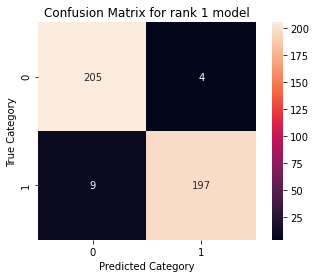

accuracy of test data: 0.9686746987951808
recall: 0.9563106796116505
precision: 0.9800995024875622
F-1 Score: 0.9680589680589681


In [85]:
clf=LogisticRegression(penalty='l1', solver='saga', C=10, max_iter=10000, tol=0.0001, random_state=42)
clf.fit(reduced_lsi_train_noclean5, train_rootlabel_numbers)
pred_test = clf.predict(reduced_lsi_test_noclean5)

#confusion matrix
plt_confusion_matrix(pred_test, 'rank 1 model')

#accuracy, recall, precision, F-1 Score
arpf(pred_test)

rank 2 model: not cleaning data, min_df=5, Lemmatization, LSI(k=500), Logistic regression with L2 regularization

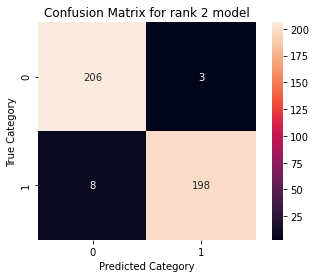

accuracy of test data: 0.9734939759036144
recall: 0.9611650485436893
precision: 0.9850746268656716
F-1 Score: 0.9729729729729729


In [86]:
clf=LogisticRegression(penalty='l2', solver='saga', C=10, max_iter=10000, tol=0.0001, random_state=42)
clf.fit(reduced_lsi_train_noclean5, train_rootlabel_numbers)
pred_test = clf.predict(reduced_lsi_test_noclean5)

#confusion matrix
plt_confusion_matrix(pred_test, 'rank 2 model')

#accuracy, recall, precision, F-1 Score
arpf(pred_test)

rank 3 model: cleaning data, min_df=5, Lemmatization, LSI(k=500), Logistic regression with L2 regularization

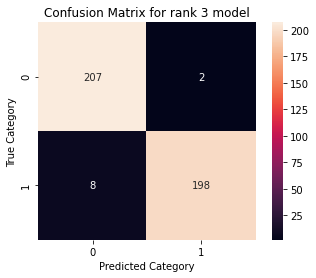

accuracy of test data: 0.9759036144578314
recall: 0.9611650485436893
precision: 0.99
F-1 Score: 0.9753694581280788


In [87]:
clf=LogisticRegression(penalty='l2', solver='saga', C=10, max_iter=10000, tol=0.0001, random_state=42)
clf.fit(reduced_lsi_train_clean5, train_rootlabel_numbers)
pred_test = clf.predict(reduced_lsi_test_clean5)

#confusion matrix
plt_confusion_matrix(pred_test, 'rank 3 model')

#accuracy, recall, precision, F-1 Score
arpf(pred_test)

rank 4 model: cleaning data, min_df=5, Lemmatization, LSI(k=500), Logistic regression with L1 regularization

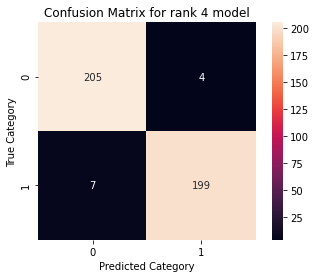

accuracy of test data: 0.9734939759036144
recall: 0.9660194174757282
precision: 0.9802955665024631
F-1 Score: 0.9731051344743277


In [88]:
clf=LogisticRegression(penalty='l1', solver='saga', C=10, max_iter=10000, tol=0.0001, random_state=42)
clf.fit(reduced_lsi_train_clean5, train_rootlabel_numbers)
pred_test = clf.predict(reduced_lsi_test_clean5)

#confusion matrix
plt_confusion_matrix(pred_test, 'rank 4 model')

#accuracy, recall, precision, F-1 Score
arpf(pred_test)

rank 5 model: not cleaning data, min_df=3, Lemmatization, LSI(k=500), Logistic regression with L2 regularization

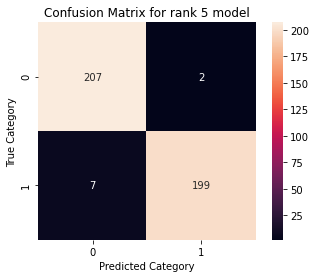

accuracy of test data: 0.9783132530120482
recall: 0.9660194174757282
precision: 0.9900497512437811
F-1 Score: 0.977886977886978


In [89]:
clf=LogisticRegression(penalty='l2', solver='saga', C=10, max_iter=10000, tol=0.0001, random_state=42)
clf.fit(reduced_lsi_train_noclean3, train_rootlabel_numbers)
pred_test = clf.predict(reduced_lsi_test_noclean3)

#confusion matrix
plt_confusion_matrix(pred_test, 'rank 5 model')

#accuracy, recall, precision, F-1 Score
arpf(pred_test)

# Question 9

In [19]:
###assigning each document leaf label names to numbers
train_leaflabel_categories={0:"chess", 1:"cricket", 2:"soccer", 3:"football", 4:"%22forest%20fire%22", 5:"flood", 6:"earthquake", 7:"drought"}
key_list = list(train_leaflabel_categories.keys())
val_list = list(train_leaflabel_categories.values())

#making a list of all document categories using category numbers
train_leaflabel_numbers = []

for row in range(train.shape[0]):
    position = val_list.index(train.iat[row,2])
    train_leaflabel_numbers.append(key_list[position])

train_leaflabel_numbers=np.asarray(train_leaflabel_numbers)
########################################
test_leaflabel_numbers = []

for row in range(test.shape[0]):
    position = val_list.index(test.iat[row,2])
    test_leaflabel_numbers.append(key_list[position])

In [20]:
def plt_confusion_matrix_multiclass(pred_test, txt):
    cmx_data = confusion_matrix(test_leaflabel_numbers, pred_test) 
    df_cmx = pd.DataFrame(cmx_data)
    sns.heatmap(df_cmx, fmt='d', annot=True, square=True)
    plt.title('Confusion Matrix for '+txt)
    plt.xlabel('Predicted Category')
    plt.ylabel('True Category')
    plt.show()
def arpf_multiclass(pred_test):
    print("accuracy of test data: "+str(accuracy_score(test_leaflabel_numbers, pred_test)))
    print("recall: "+str(recall_score(test_leaflabel_numbers, pred_test, average="macro")))
    print("precision (each category):\n"+str(precision_score(test_leaflabel_numbers, pred_test, average="macro")))
    print("F-1 Score: "+str(f1_score(test_leaflabel_numbers, pred_test, average="macro"))) 

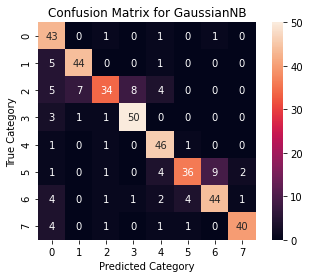

accuracy of test data: 0.8120481927710843
recall: 0.818886857738734
precision (each category):
0.8221222339792502
F-1 Score: 0.8116376305935682


In [21]:
###Naive-Bayes
clf = GaussianNB()
clf.fit(reduced_lsi_train, train_leaflabel_numbers)
pred_test = clf.predict(reduced_lsi_test)

#confusion matrix
plt_confusion_matrix_multiclass(pred_test, 'GaussianNB')

#accuracy, recall, precision, F-1 Score
arpf_multiclass(pred_test)

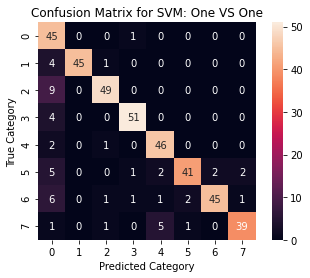

accuracy of test data: 0.8698795180722891
recall: 0.8727478146452975
precision (each category):
0.891345785030154
F-1 Score: 0.8730112320607644


In [22]:
###SVM: One VS One
clf=SVC(kernel='linear', random_state=42, probability=True, decision_function_shape='ovo')
clf.fit(reduced_lsi_train, train_leaflabel_numbers)
pred_test = clf.predict(reduced_lsi_test)

#confusion matrix
plt_confusion_matrix_multiclass(pred_test, 'SVM: One VS One')

#accuracy, recall, precision, F-1 Score
arpf_multiclass(pred_test)

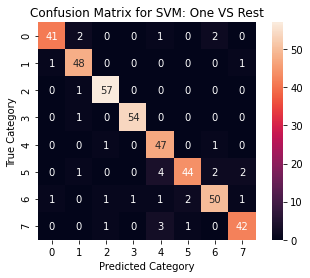

accuracy of test data: 0.9228915662650602
recall: 0.9220079383476664
precision (each category):
0.9235696557091433
F-1 Score: 0.9215785088548106


In [23]:
###SVM: One VS Rest using SMOTE
from sklearn.multiclass import OneVsRestClassifier
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
reduced_lsi_train_smote, train_leaflabel_numbers_smote = sm.fit_resample(reduced_lsi_train, train_leaflabel_numbers)

svc=SVC(kernel='linear', random_state=42, probability=True, decision_function_shape='ovr')
clf=OneVsRestClassifier(svc)
clf.fit(reduced_lsi_train_smote, train_leaflabel_numbers_smote)
pred_test = clf.predict(reduced_lsi_test)

#confusion matrix
plt_confusion_matrix_multiclass(pred_test, 'SVM: One VS Rest')

#accuracy, recall, precision, F-1 Score
arpf_multiclass(pred_test)

Class imbalance issue was solved using Synthetic Minority Over-sampling Technique (SMOTE.)
Since some misclassification is observed between categories 4-7, we attempt to merge them to combined subsets in the following sections. Accuracy increased from 86% (using One VS One) to 93% (using One VS Rest.)

Here, 2 subsets are merged (flood and earthquake):

In [24]:
###merge subset labels
#merge subset of labels=5:"flood", 6:"earthquake" to 5:"disaster"
train_leaflabel_categories={0:"chess", 1:"cricket", 2:"soccer", 3:"football", 4:"%22forest%20fire%22", 5:"disaster", 6:"drought"}
key_list = list(train_leaflabel_categories.keys())
val_list = list(train_leaflabel_categories.values())

#making a list of all document categories using category numbers
train_leaflabel_numbers = []

for row in range(train.shape[0]):
    if train.iat[row,2] == "flood" or train.iat[row,2] == "earthquake":
        position=5
    elif train.iat[row,2] == "drought":
        position=6
    else:
        position = val_list.index(train.iat[row,2])
    train_leaflabel_numbers.append(key_list[position])

train_leaflabel_numbers=np.asarray(train_leaflabel_numbers)
########################################
test_leaflabel_numbers = []

for row in range(test.shape[0]):
    if test.iat[row,2] == "flood" or test.iat[row,2] == "earthquake":
        position=5
    elif test.iat[row,2] == "drought":
        position=6
    else:
        position = val_list.index(test.iat[row,2])
    test_leaflabel_numbers.append(key_list[position])

test_leaflabel_numbers=np.asarray(test_leaflabel_numbers)

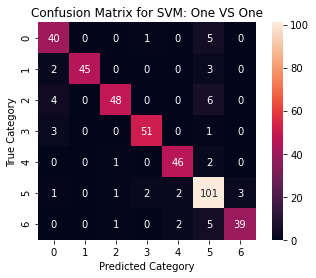

accuracy of test data: 0.891566265060241
recall: 0.887309816284148
precision (each category):
0.9079043649980318
F-1 Score: 0.8956951041754825


In [25]:
###SVM: One VS One
clf=SVC(kernel='linear', random_state=42, probability=True, decision_function_shape='ovo')
clf.fit(reduced_lsi_train, train_leaflabel_numbers)
pred_test = clf.predict(reduced_lsi_test)

#confusion matrix
plt_confusion_matrix_multiclass(pred_test, 'SVM: One VS One')

#accuracy, recall, precision, F-1 Score
arpf_multiclass(pred_test)

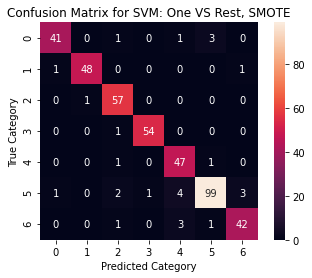

accuracy of test data: 0.9349397590361446
recall: 0.9383831207257012
precision (each category):
0.9341674721624578
F-1 Score: 0.9353311188014359


In [26]:
###SVM: One VS Rest using SMOTE
sm = SMOTE(random_state=42)
reduced_lsi_train_smote, train_leaflabel_numbers_smote = sm.fit_resample(reduced_lsi_train, train_leaflabel_numbers)

svc=SVC(kernel='linear', random_state=42, probability=True)
clf=OneVsRestClassifier(svc)
clf.fit(reduced_lsi_train_smote, train_leaflabel_numbers_smote)
pred_test = clf.predict(reduced_lsi_test)

#confusion matrix
plt_confusion_matrix_multiclass(pred_test, 'SVM: One VS Rest, SMOTE')

#accuracy, recall, precision, F-1 Score
arpf_multiclass(pred_test)

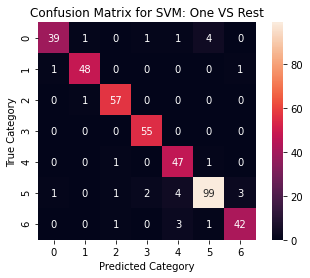

accuracy of test data: 0.9325301204819277
recall: 0.93476934319888
precision (each category):
0.9314202071325077
F-1 Score: 0.9320152770489598


In [27]:
###SVM: One VS Rest with class imbalance

svc=SVC(kernel='linear', random_state=42, probability=True)
clf=OneVsRestClassifier(svc)
clf.fit(reduced_lsi_train, train_leaflabel_numbers)
pred_test = clf.predict(reduced_lsi_test)

#confusion matrix
plt_confusion_matrix_multiclass(pred_test, 'SVM: One VS Rest')

#accuracy, recall, precision, F-1 Score
arpf_multiclass(pred_test)

In the following, 3 subsets are merged (flood, earthquake, drought):

In [28]:
###merge subset labels
#merge subset of labels=5:"flood", 6:"earthquake", 7:"drought" to 5:"disaster"
train_leaflabel_categories={0:"chess", 1:"cricket", 2:"soccer", 3:"football", 4:"%22forest%20fire%22", 5:"disaster"}
key_list = list(train_leaflabel_categories.keys())
val_list = list(train_leaflabel_categories.values())

#making a list of all document categories using category numbers
train_leaflabel_numbers = []

for row in range(train.shape[0]):
    if train.iat[row,2] == "flood" or train.iat[row,2] == "earthquake" or train.iat[row,2] =="drought":
        position=5
    else:
        position = val_list.index(train.iat[row,2])
    train_leaflabel_numbers.append(key_list[position])

train_leaflabel_numbers=np.asarray(train_leaflabel_numbers)
########################################
test_leaflabel_numbers = []

for row in range(test.shape[0]):
    if test.iat[row,2] == "flood" or test.iat[row,2] == "earthquake" or test.iat[row,2] == "drought":
        position=5
    else:
        position = val_list.index(test.iat[row,2])
    test_leaflabel_numbers.append(key_list[position])

test_leaflabel_numbers=np.asarray(test_leaflabel_numbers)

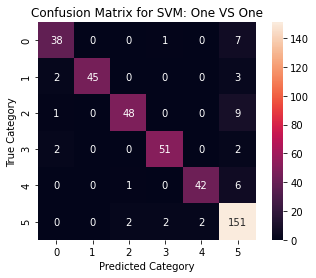

accuracy of test data: 0.9036144578313253
recall: 0.88331203122072
precision (each category):
0.928700317758711
F-1 Score: 0.9037555184258718


In [29]:
###SVM: One VS One
clf=SVC(kernel='linear', random_state=42, probability=True, decision_function_shape='ovo')
clf.fit(reduced_lsi_train, train_leaflabel_numbers)
pred_test = clf.predict(reduced_lsi_test)

#confusion matrix
plt_confusion_matrix_multiclass(pred_test, 'SVM: One VS One')

#accuracy, recall, precision, F-1 Score
arpf_multiclass(pred_test)

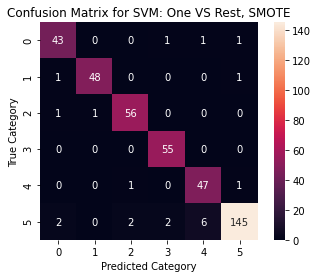

accuracy of test data: 0.9493975903614458
recall: 0.9571750670875404
precision (each category):
0.9403356597163196
F-1 Score: 0.9480975780909504


In [30]:
###SVM: One VS Rest
sm = SMOTE(random_state=42)
reduced_lsi_train_smote, train_leaflabel_numbers_smote = sm.fit_resample(reduced_lsi_train, train_leaflabel_numbers)

svc=SVC(kernel='linear', random_state=42, probability=True)
clf=OneVsRestClassifier(svc)
clf.fit(reduced_lsi_train_smote, train_leaflabel_numbers_smote)
pred_test = clf.predict(reduced_lsi_test)

#confusion matrix
plt_confusion_matrix_multiclass(pred_test, 'SVM: One VS Rest, SMOTE')

#accuracy, recall, precision, F-1 Score
arpf_multiclass(pred_test)

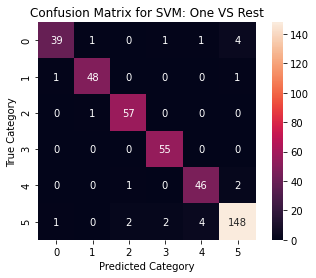

accuracy of test data: 0.946987951807229
recall: 0.9453392295143211
precision (each category):
0.9443824780425388
F-1 Score: 0.9441371158674604


In [31]:
###SVM: One VS Rest with class imbalance

svc=SVC(kernel='linear', random_state=42, probability=True)
clf=OneVsRestClassifier(svc)
clf.fit(reduced_lsi_train, train_leaflabel_numbers)
pred_test = clf.predict(reduced_lsi_test)

#confusion matrix
plt_confusion_matrix_multiclass(pred_test, 'SVM: One VS Rest')

#accuracy, recall, precision, F-1 Score
arpf_multiclass(pred_test)

In the following, 4 subsets are merged (forest fire, flood, earthquake, drought):

In [33]:
###merge subset labels
#merge subset of labels=5:"flood", 6:"earthquake", 7:"drought" to 5:"disaster"
train_leaflabel_categories={0:"chess", 1:"cricket", 2:"soccer", 3:"football", 4:"disaster"}
key_list = list(train_leaflabel_categories.keys())
val_list = list(train_leaflabel_categories.values())

#making a list of all document categories using category numbers
train_leaflabel_numbers = []

for row in range(train.shape[0]):
    if train.iat[row,2] == "%22forest%20fire%22" or train.iat[row,2] == "flood" or train.iat[row,2] == "earthquake" or train.iat[row,2] =="drought":
        position=4
    else:
        position = val_list.index(train.iat[row,2])
    train_leaflabel_numbers.append(key_list[position])

train_leaflabel_numbers=np.asarray(train_leaflabel_numbers)
########################################
test_leaflabel_numbers = []

for row in range(test.shape[0]):
    if test.iat[row,2] == "%22forest%20fire%22" or test.iat[row,2] == "flood" or test.iat[row,2] == "earthquake" or test.iat[row,2] == "drought":
        position=4
    else:
        position = val_list.index(test.iat[row,2])
    test_leaflabel_numbers.append(key_list[position])

test_leaflabel_numbers=np.asarray(test_leaflabel_numbers)

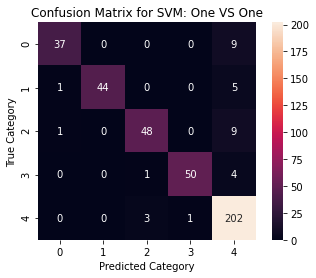

accuracy of test data: 0.9180722891566265
recall: 0.8803214932692522
precision (each category):
0.9468566197053224
F-1 Score: 0.9103235158772701


In [34]:
###SVM: One VS One
clf=SVC(kernel='linear', random_state=42, probability=True, decision_function_shape='ovo')
clf.fit(reduced_lsi_train, train_leaflabel_numbers)
pred_test = clf.predict(reduced_lsi_test)

#confusion matrix
plt_confusion_matrix_multiclass(pred_test, 'SVM: One VS One')

#accuracy, recall, precision, F-1 Score
arpf_multiclass(pred_test)

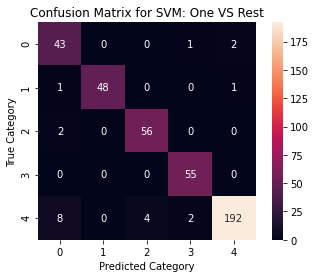

accuracy of test data: 0.9493975903614458
recall: 0.9584677370052838
precision (each category):
0.9325041752627958
F-1 Score: 0.943960338315722


In [35]:
###SVM: One VS Rest
sm = SMOTE(random_state=42)
reduced_lsi_train_smote, train_leaflabel_numbers_smote = sm.fit_resample(reduced_lsi_train, train_leaflabel_numbers)

svc=SVC(kernel='linear', random_state=42, probability=True)
clf=OneVsRestClassifier(svc)
clf.fit(reduced_lsi_train_smote, train_leaflabel_numbers_smote)
pred_test = clf.predict(reduced_lsi_test)

#confusion matrix
plt_confusion_matrix_multiclass(pred_test, 'SVM: One VS Rest')

#accuracy, recall, precision, F-1 Score
arpf_multiclass(pred_test)

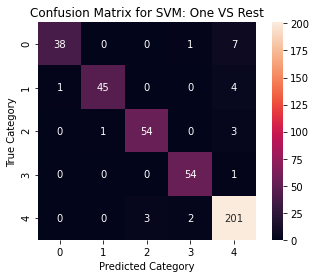

accuracy of test data: 0.944578313253012
recall: 0.9229335552876694
precision (each category):
0.9555824483170021
F-1 Score: 0.9375280862396472


In [30]:
###SVM: One VS Rest with class imbalance

svc=SVC(kernel='linear', random_state=42, probability=True)
clf=OneVsRestClassifier(svc)
clf.fit(reduced_lsi_train, train_leaflabel_numbers)
pred_test = clf.predict(reduced_lsi_test)

#confusion matrix
plt_confusion_matrix_multiclass(pred_test, 'SVM: One VS Rest')

#accuracy, recall, precision, F-1 Score
arpf_multiclass(pred_test)

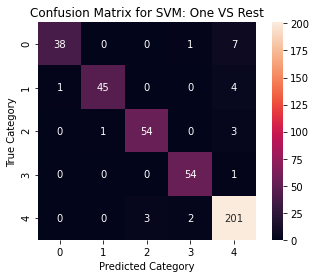

accuracy of test data: 0.944578313253012
recall: 0.9229335552876694
precision (each category):
0.9555824483170021
F-1 Score: 0.9375280862396472


In [36]:
###SVM: One VS Rest with class imbalance

svc=SVC(kernel='linear', random_state=42, probability=True)
clf=OneVsRestClassifier(svc)
clf.fit(reduced_lsi_train, train_leaflabel_numbers)
pred_test = clf.predict(reduced_lsi_test)

#confusion matrix
plt_confusion_matrix_multiclass(pred_test, 'SVM: One VS Rest')

#accuracy, recall, precision, F-1 Score
arpf_multiclass(pred_test)

Once some classes are merged, there is increased disparity in the accuracy levels between the classifiers that remove class imbalance and the ones that don't. Hence, the resolution is approximately when there is less than 5 categories. With less than 5, apparent difference is observed between class imbalanced data and SMOTE processed data.

# Question 10

(a) It is because the ratio of co-occurrence probabilities are more effective to seperate the groups of contexual words. For these groups of words which are related to the target word in the co-occurrence ratio, the ratio will be either very large or very small. On the other hand, the probabilities themselves will be affected by the noise and become difficult to find relevant words from corpus.

(b) It will not return the same vector because it uses conditional probability ratios to represent relationships with different words. For example, in these two cases, the relationships with 'presidency' and 'park' are different.

In [50]:
#Create a folder named 'glove' in the project directorty and put 'glove.6B.300d.txt' into it
embeddings_dict = {}
dimension_of_glove = 300
with open("glove/glove.6B.300d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [51]:
#(c) Practical
from numpy.linalg import norm
print("Value1: {}".format(norm(embeddings_dict['queen'] - embeddings_dict['king'] - embeddings_dict['wife'] + embeddings_dict['husband'])))
print("Value2: {}".format(norm(embeddings_dict['queen'] - embeddings_dict['king'])))
print("Value3: {}".format(norm(embeddings_dict['wife'] - embeddings_dict['husband'])))

Value1: 6.165036201477051
Value2: 5.9662580490112305
Value3: 3.1520464420318604


(c)
Expected (ideal):
||queen - king - wife + husband||2 = ||(queen - king) - (wife - husband)||2 = ||(female) - (female)||2 = 0
It is because a possible contextual word embedding transforms 'king' to 'queen' and 'husband' to 'wife' is the word 'female'.

Practical:
||queen - king - wife + husband||2 = 6.16504
||queen - king||2 = 5.96626
||wife - husband||2 = 3.15205

(d) We would choose lemmatization. Even though stemming is faster than lemmatization, lemmatization considers the syntax, context, etc. It usually has the lower error rate than stemming.

# Question 11

(a) First, we choose the column keywords as our features, split the data into 'keywords' and 'rootlabel', tokenize each keyword in keywords in each sample, generate a matrix mxn (m=the number of samples, n=300 in this case), add each vector of the keywords of one sample in the embedding-dictionary, and normalize each row of the vector.

(b) We select SVM model and use cross-validation to find the best parameter, gamma. Gamma shoud be 1 in this case (n=300).

In [52]:
np.random.seed(42)
random.seed(42)

glove_train, glove_test = train_test_split(data[["keywords","root_label"]], test_size=0.2)
print("training samples = "+str(len(glove_train))+"\n"+"test samples = "+str(len(glove_test)))

training samples = 1657
test samples = 415


In [53]:
train_keywords = []
test_keywords = []

for row in range(glove_train.shape[0]):
    train_keywords.append(glove_train.iat[row, 0])
for row in range(glove_test.shape[0]):
    test_keywords.append(glove_test.iat[row, 0])

glove_train_keywords = []
glove_test_keywords = []

for keywords in train_keywords:
    keywords = keywords.replace('\'', '')
    keywords = keywords.replace(',', '')
    keywords = keywords.replace('[', '')
    keywords = keywords.replace(']', '')
    wordlist = []
    for keyword in nltk.word_tokenize(keywords):
        if keyword in embeddings_dict:
            wordlist.append(keyword)
    glove_train_keywords.append(wordlist)

for keywords in test_keywords:
    keywords = keywords.replace('\'', '')
    keywords = keywords.replace(',', '')
    keywords = keywords.replace('[', '')
    keywords = keywords.replace(']', '')
    wordlist = []
    for keyword in nltk.word_tokenize(keywords):
        if keyword in embeddings_dict:
            wordlist.append(keyword)
    glove_test_keywords.append(wordlist)

In [54]:
from sklearn.preprocessing import normalize

rows = glove_train.shape[0]
cols = dimension_of_glove
glove_train_matrix = np.zeros(shape=(rows, cols))

for row in range(rows):
    for keyword in glove_train_keywords[row]:
        if keyword in embeddings_dict:
            glove_train_matrix[row] += embeddings_dict[keyword]
    glove_train_matrix[row] = normalize(glove_train_matrix[row][:,np.newaxis], axis=0).ravel()

rows = glove_test.shape[0]
glove_test_matrix = np.zeros(shape=(rows, cols))

for row in range(rows):
    for keyword in glove_test_keywords[row]:
        if keyword in embeddings_dict:
            glove_test_matrix[row] += embeddings_dict[keyword]
    glove_test_matrix[row] = normalize(glove_test_matrix[row][:,np.newaxis], axis=0).ravel()

In [55]:
###assigning each document category names to category numbers
#making a list of all category types
#0:sports; 1:climate
glove_train_rootlabel_categories = data['root_label'].value_counts().index.tolist()

#making a list of all document categories using category numbers
glove_train_rootlabel_numbers = []
for row in range(glove_train.shape[0]):
    for i, s in enumerate(glove_train_rootlabel_categories):
        if glove_train.iat[row, 1] == s:
            glove_train_rootlabel_numbers.append(i)
            break
glove_train_rootlabel_numbers = np.asarray(glove_train_rootlabel_numbers)

glove_test_rootlabel_numbers = []
for row in range(glove_test.shape[0]):
    for i, s in enumerate(glove_train_rootlabel_categories):
        if glove_test.iat[row, 1] == s:
            glove_test_rootlabel_numbers.append(i)
            break
glove_test_rootlabel_numbers = np.asarray(glove_test_rootlabel_numbers)

In [56]:
def plt_roc_curve_glove(model, txt):
    prob = model.predict_proba(glove_test_matrix)[:,1]
    fpr, tpr, thresholds = roc_curve(glove_test_rootlabel_numbers, prob)
    plt.plot(fpr, tpr)
    plt.title("ROC Curve: "+txt)
    plt.xlabel('FPR: False positive rate')
    plt.ylabel('TPR: True positive rate')
    plt.show()

def plt_confusion_matrix_glove(pred_test, txt):
    cmx_data = confusion_matrix(glove_test_rootlabel_numbers, pred_test) 
    df_cmx = pd.DataFrame(cmx_data)
    sns.heatmap(df_cmx, fmt='d', annot=True, square=True)
    plt.title('Confusion Matrix for '+txt)  
    plt.xlabel('Predicted Category')
    plt.ylabel('True Category')
    plt.show()

def arpf_glove(pred_test):
    print("accuracy of test data: "+str(accuracy_score(glove_test_rootlabel_numbers, pred_test)))
    print("recall: "+str(recall_score(glove_test_rootlabel_numbers, pred_test)))
    print("precision: "+str(precision_score(glove_test_rootlabel_numbers, pred_test)))
    print("F-1 Score: "+str(f1_score(glove_test_rootlabel_numbers, pred_test)))

Best Parameters: {'C': 1}
Best Score: 0.9444672951625233


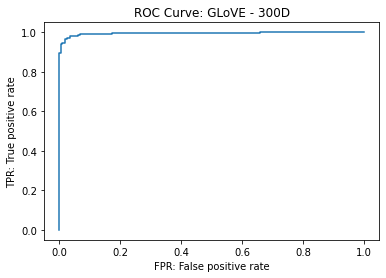

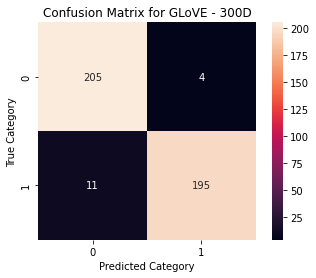

accuracy of test data: 0.963855421686747
recall: 0.9466019417475728
precision: 0.9798994974874372
F-1 Score: 0.9629629629629629


In [57]:
candidate_params = {'C': [10**i for i in range(-3, 7)]}

svc_glove = SVC(kernel='linear', random_state=42, probability=True)
clf_glove = GridSearchCV(estimator=svc_glove, param_grid=candidate_params, cv=5, n_jobs=-1)

clf_glove.fit(glove_train_matrix, glove_train_rootlabel_numbers)
print("Best Parameters: "+str(clf_glove.best_params_))
print("Best Score: "+str(clf_glove.best_score_))

#training classifier and predicting
clf_glove = SVC(kernel='linear', random_state=0, C=clf_glove.best_params_['C'], probability=True)
clf_glove.fit(glove_train_matrix, glove_train_rootlabel_numbers)

pred_test_glove = clf_glove.predict(glove_test_matrix)

#ROC curve
plt_roc_curve_glove(clf_glove, 'GLoVE - 300D')

#confusion matrix
plt_confusion_matrix_glove(pred_test_glove, 'GLoVE - 300D')

#accuracy, recall, precision, F-1 Score
arpf_glove(pred_test_glove)

# Question 12


Training glove.6B.50d.txt ......


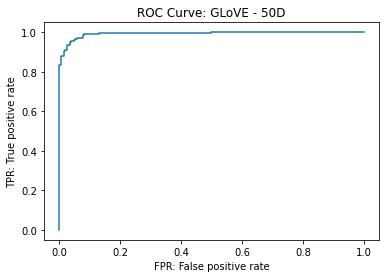

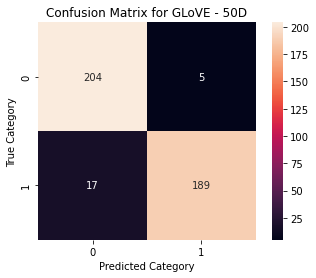

accuracy of test data: 0.946987951807229
recall: 0.9174757281553398
precision: 0.9742268041237113
F-1 Score: 0.9450000000000001

Training glove.6B.100d.txt ......


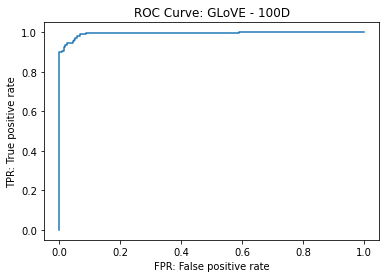

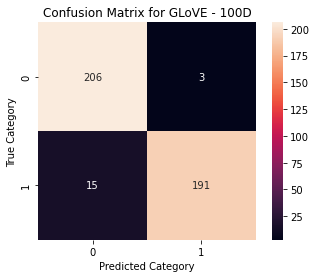

accuracy of test data: 0.9566265060240964
recall: 0.9271844660194175
precision: 0.9845360824742269
F-1 Score: 0.9550000000000001

Training glove.6B.200d.txt ......


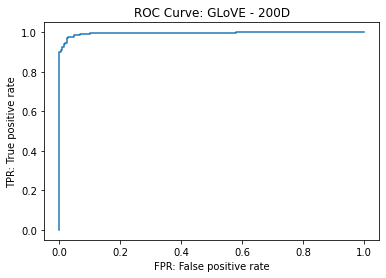

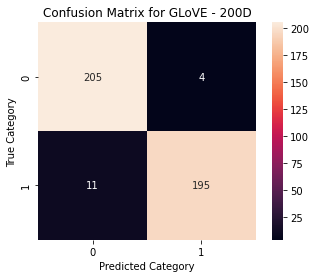

accuracy of test data: 0.963855421686747
recall: 0.9466019417475728
precision: 0.9798994974874372
F-1 Score: 0.9629629629629629

Training glove.6B.300d.txt ......


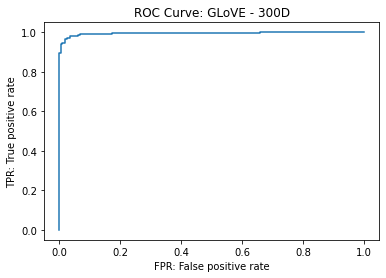

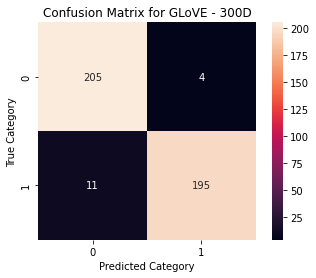

accuracy of test data: 0.963855421686747
recall: 0.9466019417475728
precision: 0.9798994974874372
F-1 Score: 0.9629629629629629

Accuracy: [0.946987951807229, 0.9566265060240964, 0.963855421686747, 0.963855421686747]



In [58]:
filenames = ['glove.6B.50d.txt', 'glove.6B.100d.txt', 'glove.6B.200d.txt', 'glove.6B.300d.txt']
dimensions = [50, 100, 200, 300]
accuracy = []

for i in range(4):
    #Step1: Loading
    print("\nTraining {} ......".format(filenames[i]))
    embeddings_dict = {}
    dimension_of_glove = dimensions[i]
    with open("glove/"+filenames[i], 'r') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], "float32")
            embeddings_dict[word] = vector

    #Step2: Constructing Matrix
    rows = glove_train.shape[0]
    cols = dimension_of_glove
    glove_train_matrix = np.zeros(shape=(rows, cols))
    for row in range(rows):
        for keyword in glove_train_keywords[row]:
            if keyword in embeddings_dict:
                glove_train_matrix[row] += embeddings_dict[keyword]
        glove_train_matrix[row] = normalize(glove_train_matrix[row][:,np.newaxis], axis=0).ravel()

    rows = glove_test.shape[0]
    glove_test_matrix = np.zeros(shape=(rows, cols))
    for row in range(rows):
        for keyword in glove_test_keywords[row]:
            if keyword in embeddings_dict:
                glove_test_matrix[row] += embeddings_dict[keyword]
        glove_test_matrix[row] = normalize(glove_test_matrix[row][:,np.newaxis], axis=0).ravel()

    #Step3: Training
    #training classifier and predicting
    clf_glove = SVC(kernel='linear', random_state=42, C=1, probability=True)
    clf_glove.fit(glove_train_matrix, glove_train_rootlabel_numbers)
    pred_test_glove = clf_glove.predict(glove_test_matrix)

    #ROC curve
    plt_roc_curve_glove(clf_glove, 'GLoVE - '+str(dimension_of_glove)+'D')

    #confusion matrix
    plt_confusion_matrix_glove(pred_test_glove, 'GLoVE - '+str(dimension_of_glove)+'D')

    #accuracy, recall, precision, F-1 Score
    arpf_glove(pred_test_glove)
    accuracy.append(accuracy_score(glove_test_rootlabel_numbers, pred_test_glove))

print("\nAccuracy: {}\n".format(accuracy))

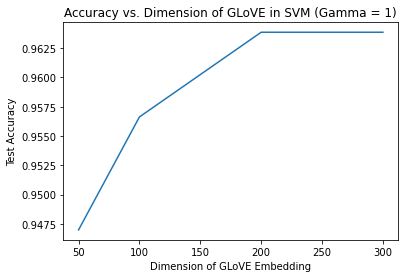

In [59]:
plt.plot(dimensions, accuracy)
plt.title("Accuracy vs. Dimension of GLoVE in SVM (Gamma = 1)")
plt.xlabel("Dimension of GLoVE Embedding")
plt.ylabel("Test Accuracy")
plt.show()

We repeated use SVM classifier on dimension (50, 100, 200, 300) with fixed Gamma=1 because the best parameter we found in Question11 was Gamma=1 and it is better to demonstrate the trend with fixed parameter (control variable).

We can expect the trend looks like this plot. It is because with more dimensions of GLoVE embedding, we have more information about the words and co-occurrence probability ratios between target words and context words. Hence, the accuracy increases. The increases from 50->100 and 100->200 are obvious because the dimensions are doubled.

# Question 13

In [60]:
import umap
import umap.plot

reducer_glove = umap.UMAP(n_components=2, random_state=42)
reducer_glove = reducer_glove.fit(glove_train_matrix)

In [61]:
print("The shape of the reducer_glove is ({}, {})".format(reducer_glove.embedding_.shape[0], reducer_glove.embedding_.shape[1]))

The shape of the reducer_glove is (1657, 2)


In [62]:
#0:sports; 1:climate
glove_train_rootlabel_text = []
for label in glove_train_rootlabel_numbers:
    if label == 0:
        glove_train_rootlabel_text.append("sports")
    else:
        glove_train_rootlabel_text.append("climate")

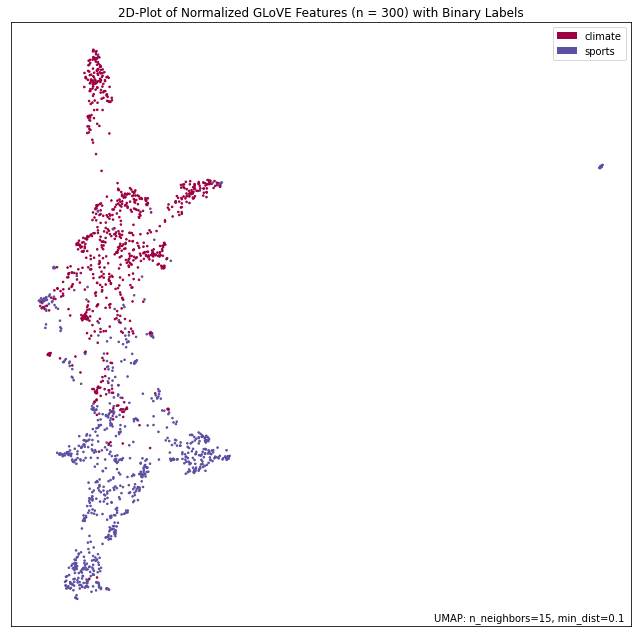

In [63]:
p1ot_glove = umap.plot.points(reducer_glove, labels=np.array(glove_train_rootlabel_text))
plt.title('2D-Plot of Normalized GLoVE Features (n = 300) with Binary Labels')
plt.show()

In [64]:
np.random.seed(42)
random.seed(42)

rv = np.random.rand(reducer_glove.embedding_.shape[0], 300) #uniform distribution over [0, 1)
for row in range(rv.shape[0]):
    rv[row] = normalize(rv[row][:,np.newaxis], axis=0).ravel()

reducer_rv = umap.UMAP(n_components=2, random_state=42)
reducer_rv = reducer_rv.fit(rv)

In [65]:
np.random.seed(42)
random.seed(42)

#0:sports; 1:climate
rv_labels = np.random.randint(2, size=reducer_glove.embedding_.shape[0]) #Uniform Random

rv_text = []
for label in rv_labels:
    if label == 0:
        rv_text.append("sports")
    else:
        rv_text.append("climate")

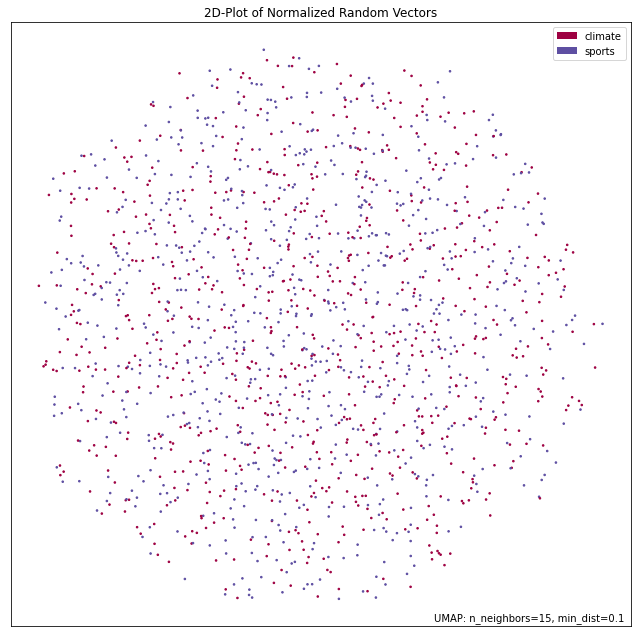

In [66]:
plot_rv = umap.plot.points(reducer_rv, labels=np.array(rv_text))
plt.title('2D-Plot of Normalized Random Vectors')
plt.show()

In both cases, we use the dimension=300, and we use uniform distribution over [0, 1) in random vectors, normalize them, and randomly assign them two different labels (sports and climate).

We can only see clusters from the plot of GLoVE features (actual dataset), and it is expected because the GLoVE embeddings truly provide much information to distinguish features. On the other hand, we can't see any clusters from the plot of random vectors because it is uniformly distributed.